# Plots and Tables for the DOE Analyses

### National Renewable Energy Laboratory

#### Rob Hammond
##### 18 July 2020

In [1]:
import os
import re
from copy import deepcopy

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches

from wombat.simulation import WombatEnvironment
from wombat.windfarm import Windfarm
from wombat.windfarm.system import System
from wombat.simulation.repairs import RepairManager
from wombat.simulation.transport import Equipment

%matplotlib inline

pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)

## Quick refresh on running a simulation and saving the outputs

In [2]:
# simulation_name = "offshore_base_3_month_summer"
# weather = "vineyard_wind_weather_1998_2017.csv"
# layout = "dudgeon_array.csv"
# crane = "offshore_jackup_3_month_summer.yaml"
# crew_transfer = "offshore_ctv.yaml"
# cable = "cable_vessel_3_month_summer.yaml"
# library_path = "/Users/rhammond/Documents/GitHub/wombat/library/"

# #### THE SETUP ####
# env = WombatEnvironment(library_path, weather, simulation_name=simulation_name, workday_start=8, workday_end=18)
# manager = RepairManager(env)
# windfarm = Windfarm(env, layout, manager)

# crn = Equipment(env, windfarm, manager, crane)
# ctv = Equipment(env,windfarm, manager, crew_transfer)
# cab = Equipment(env, windfarm, manager, cable)

# #### RUN THE SCENARIO ####
# env.run()

# events = env.create_events_log_dataframe()
# operations = env.create_operations_log_dataframe()

# events_save_path = os.path.join(library_path, "outputs", "csv_logs", f"{simulation_name}_events.csv")
# events.sort_values("env_time").to_csv(events_save_path, index_label="datetime")

# turbine_columns = [col for col in operations if col not in ("env_datetime", "env_time", "DOW_OSS")]
# column_order = ["env_datetime", "env_time", "windfarm", "DOW_OSS"] + turbine_columns

# operations["windfarm"] = operations["DOW_OSS"].values * np.mean(operations[turbine_columns].values, axis=1)
# operations = operations[column_order]

# operations_save_path = os.path.join(library_path, "outputs", "csv_logs", f"{simulation_name}_operations.csv")
# operations.sort_values("env_time").to_csv(operations_save_path, index_label="datetime")

## Helper Functions

In [3]:
def equipment_labor_cost_breakdown(events_df, equipment, total_mw, years):
    events_df = (
        events_df[
            events_df.agent.isin(equipment)
            & events_df.action.isin(["delay", "repair", "maintenance"])
            & ~events_df.reason.isin(["Work is complete"])
        ]
        .groupby(["action", "reason"])
        .sum()
    )

    non_hours = [
        ("delay", "Not in working hours."),
        ("delay", "Work shift has ended. Waiting for next shift to start"),
    ]
    events_df.loc[("delay", "Not in Shift"), :] = events_df.loc[non_hours].sum(axis=0)
    events_df = events_df.drop(index=non_hours)

    events_df.loc[("working", "working"), :] = events_df.loc["maintenance"].sum(
        axis=0
    ) + events_df.loc["repair"].sum(axis=0)
    events_df = events_df.drop(
        index=[el for el in events_df.index if el[0] in ("repair", "maintenance")]
    )

    events_df = events_df.loc[:, ["total_cost"]]
    events_df = events_df.droplevel(0)

    events_df = events_df / total_mw / years

    events_df = events_df.rename(
        index={
            "No requests": "No Requests",
            "weather delay": "Weather Delay",
            "Not in Shift": "Outside Working Hours",
            "working": "Working",
        }
    )

    return events_df


def make_label_multi_lines(text: str, longest_line_length: int = 12) -> str:
    new_text = ""
    while len(text) > longest_line_length:
        space_ix = np.array([m.start() for m in re.finditer(" ", text)])
        if space_ix.size == 0:
            break
        ix = np.argmin(np.abs(space_ix - longest_line_length))
        new_text = f"{new_text}\n{text[:space_ix[ix]]}"
        text = text[space_ix[ix] + 1 :]

    return f"{new_text}\n{text}".strip()

## Setting up the Data

In [4]:
years = range(1998, 2018)
months = range(1, 13)
library_path = "/Users/rhammond/Documents/GitHub/wombat/library/"

month_map = {
    1: "Jan",
    2: "Feb",
    3: "Mar",
    4: "Apr",
    5: "May",
    6: "Jun",
    7: "Jul",
    8: "Aug",
    9: "Sep",
    10: "Oct",
    11: "Nov",
    12: "Dec",
}

offshore_total_mw = 67 * 10
onshore_total_mw = 67 * 3
cost_columns = ["total_labor_cost", "materials_cost", "equipment_cost", "total_cost"]
offshore_equipment = ["Jack-up Vessel", "Cable Laying Vessel", "Windcat MK III"]
onshore_equipment = ["Crawler Crane", "Onshore Cabling", "Truck"]

In [5]:
cost_format_dict = {
    "materials_cost": {
        "name": "Materials",
        "color": "#027A3E",
    },
    "hourly_labor_cost": {
        "name": "Hourly Labor",
        "color": "#ffffff",
    },
    "salary_labor_cost": {
        "name": "Salaried Labor",
        "color": "#ffffff",
    },
    "equipment_cost": {
        "name": "Equipment",
        "color": "#ffffff",
    },
    "total_labor_cost": {
        "name": "Total Labor",
        "color": "#049BD6",
    },
    "total_cost": {
        "name": "Total",
        "color": "#035068",
    },
    "Jack-up Vessel": {
        "name": "Crane",
        "color": "#FBD876",
    },
    "Crawler Crane": {
        "name": "Crane",
        "color": "#FBD876",
    },
    "Truck": {
        "name": "Crew Transfer",
        "color": "#83C554",
    },
    "Windcat MK III": {
        "name": "Crew Transfer",
        "color": "#83C554",
    },
    "Onshore Cabling": {
        "name": "Cable",
        "color": "#E37225",
    },
    "Cable Laying Vessel": {
        "name": "Cable",
        "color": "#E37225",
    },
}

In [6]:
scenarios = {
    #### OFFSHORE ####
    "offshore_base_3_month_summer": [
        "vineyard_wind_weather_1998_2017.csv",
        "offshore_dudgeon_array.csv",
        "offshore_jackup_3_month_summer.yaml",
        "offshore_ctv.yaml",
        "cable_vessel_3_month_summer.yaml",
    ],
    "offshore_base_no_weather_3_month_summer": [
        "vineyard_wind_weather_1998_2017_no_wind_wave.csv",
        "offshore_dudgeon_array.csv",
        "offshore_jackup_3_month_summer.yaml",
        "offshore_ctv.yaml",
        "cable_vessel_3_month_summer.yaml",
    ],
    "offshore_double_3_month_summer": [
        "vineyard_wind_weather_1998_2017.csv",
        "offshore_dudgeon_array_double.csv",
        "offshore_jackup_3_month_summer.yaml",
        "offshore_ctv.yaml",
        "cable_vessel_3_month_summer.yaml",
    ],
    "offshore_half_3_month_summer": [
        "vineyard_wind_weather_1998_2017.csv",
        "offshore_dudgeon_array_half.csv",
        "offshore_jackup_3_month_summer.yaml",
        "offshore_ctv.yaml",
        "cable_vessel_3_month_summer.yaml",
    ],
    "offshore_12_month": [
        "vineyard_wind_weather_1998_2017.csv",
        "offshore_dudgeon_array.csv",
        "offshore_jackup_12_month.yaml",
        "offshore_ctv.yaml",
        "cable_vessel_12_month.yaml",
    ],
    "offshore_0_month": [
        "vineyard_wind_weather_1998_2017.csv",
        "offshore_dudgeon_array.csv",
        None,
        None,
        None,
    ],
    "offshore_base_2_month_summer": [
        "vineyard_wind_weather_1998_2017.csv",
        "offshore_dudgeon_array.csv",
        "offshore_jackup_2_month_summer.yaml",
        "offshore_ctv.yaml",
        "cable_vessel_2_month_summer.yaml",
    ],
    "offshore_base_no_weather_2_month_summer": [
        "vineyard_wind_weather_1998_2017_no_wind_wave.csv",
        "offshore_dudgeon_array.csv",
        "offshore_jackup_2_month_summer.yaml",
        "offshore_ctv.yaml",
        "cable_vessel_2_month_summer.yaml",
    ],
    "offshore_base_1_month_summer": [
        "vineyard_wind_weather_1998_2017.csv",
        "offshore_dudgeon_array.csv",
        "offshore_jackup_1_month_summer.yaml",
        "offshore_ctv.yaml",
        "cable_vessel_1_month_summer.yaml",
    ],
    "offshore_base_no_weather_1_month_summer": [
        "vineyard_wind_weather_1998_2017_no_wind_wave.csv",
        "offshore_dudgeon_array.csv",
        "offshore_jackup_1_month_summer.yaml",
        "offshore_ctv.yaml",
        "cable_vessel_1_month_summer.yaml",
    ],
    "offshore_base_3_month_fall": [
        "vineyard_wind_weather_1998_2017.csv",
        "offshore_dudgeon_array.csv",
        "offshore_jackup_3_month_fall.yaml",
        "offshore_ctv.yaml",
        "cable_vessel_3_month_fall.yaml",
    ],
    "offshore_base_3_month_winter": [
        "vineyard_wind_weather_1998_2017.csv",
        "offshore_dudgeon_array.csv",
        "offshore_jackup_3_month_winter.yaml",
        "offshore_ctv.yaml",
        "cable_vessel_3_month_winter.yaml",
    ],
    "offshore_base_3_month_spring": [
        "vineyard_wind_weather_1998_2017.csv",
        "offshore_dudgeon_array.csv",
        "offshore_jackup_3_month_spring.yaml",
        "offshore_ctv.yaml",
        "cable_vessel_3_month_spring.yaml",
    ],
    #### ONSHORE ####
    "onshore_base_3_month_summer": [
        "sweetwater_weather_1998_2017.csv",
        "onshore_dudgeon_array.csv",
        "onshore_crawler_3_month_summer.yaml",
        "onshore_onsite.yaml",
        "onshore_cable_3_month_summer.yaml",
    ],
    "onshore_base_no_weather_3_month_summer": [
        "sweetwater_weather_1998_2017.csv",
        "onshore_dudgeon_array.csv",
        "onshore_crawler_3_month_summer.yaml",
        "onshore_onsite.yaml",
        "onshore_cable_3_month_summer.yaml",
    ],
    "onshore_double_3_month_summer": [
        "sweetwater_weather_1998_2017.csv",
        "onshore_dudgeon_array_double.csv",
        "onshore_crawler_3_month_summer.yaml",
        "onshore_onsite.yaml",
        "onshore_cable_3_month_summer.yaml",
    ],
    "onshore_half_3_month_summer": [
        "sweetwater_weather_1998_2017.csv",
        "onshore_dudgeon_array_half.csv",
        "onshore_crawler_3_month_summer.yaml",
        "onshore_onsite.yaml",
        "onshore_cable_3_month_summer.yaml",
    ],
    "onshore_12_month": [
        "sweetwater_weather_1998_2017.csv",
        "onshore_dudgeon_array.csv",
        "onshore_crawler_12_month.yaml",
        "onshore_onsite.yaml",
        "onshore_cable_12_month.yaml",
    ],
    "onshore_0_month": [
        "sweetwater_weather_1998_2017.csv",
        "onshore_dudgeon_array.csv",
        None,
        None,
        None,
    ],
    "onshore_base_2_month_summer": [
        "sweetwater_weather_1998_2017.csv",
        "onshore_dudgeon_array.csv",
        "onshore_crawler_2_month_summer.yaml",
        "onshore_onsite.yaml",
        "onshore_cable_2_month_summer.yaml",
    ],
    "onshore_base_no_weather_2_month_summer": [
        "sweetwater_weather_1998_2017.csv",
        "onshore_dudgeon_array.csv",
        "onshore_crawler_2_month_summer.yaml",
        "onshore_onsite.yaml",
        "onshore_cable_2_month_summer.yaml",
    ],
    "onshore_base_1_month_summer": [
        "sweetwater_weather_1998_2017.csv",
        "onshore_dudgeon_array.csv",
        "onshore_crawler_1_month_summer.yaml",
        "onshore_onsite.yaml",
        "onshore_cable_1_month_summer.yaml",
    ],
    "onshore_base_no_weather_1_month_summer": [
        "sweetwater_weather_1998_2017.csv",
        "onshore_dudgeon_array.csv",
        "onshore_crawler_1_month_summer.yaml",
        "onshore_onsite.yaml",
        "onshore_cable_1_month_summer.yaml",
    ],
    "onshore_base_3_month_fall": [
        "sweetwater_weather_1998_2017.csv",
        "onshore_dudgeon_array.csv",
        "onshore_crawler_3_month_fall.yaml",
        "onshore_onsite.yaml",
        "onshore_cable_3_month_fall.yaml",
    ],
    "onshore_base_3_month_winter": [
        "sweetwater_weather_1998_2017.csv",
        "onshore_dudgeon_array.csv",
        "onshore_crawler_3_month_winter.yaml",
        "onshore_onsite.yaml",
        "onshore_cable_3_month_winter.yaml",
    ],
    "onshore_base_3_month_spring": [
        "sweetwater_weather_1998_2017.csv",
        "onshore_dudgeon_array.csv",
        "onshore_crawler_3_month_spring.yaml",
        "onshore_onsite.yaml",
        "onshore_cable_3_month_spring.yaml",
    ],
}

In [7]:
format_categories = [
    dict(
        name="Base Scenario",
        color="#035068",
        marker_color="#035068",
        linestyle="-",
        marker="o",
    ),
    dict(
        name="No Weather",
        color="#818386",
        marker_color="#FBD876",
        linestyle="dashed",
        marker="P",
    ),
    dict(
        name="Change in MTBF",
        color="#83C554",
        marker_color="#83C554",
        linestyle="-",
        alpha=0.6,
        marker="o",
    ),
    dict(
        name="Change in Visit Length",
        color="#818386",
        marker_color="#E37225",
        linestyle="-",
        marker="d",
    ),
    dict(
        name="Change in Season",
        color="#818386",
        marker_color="#027A3E",
        linestyle="dotted",
        marker="s",
    ),
]

format_dict = {
    #### OFFSHORE ###
    "offshore_base_3_month_summer": {
        "name": "Base (3 Month Summer Visit)",
        "format": dict(
            color="#035068", marker_color="#035068", linestyle="-", alpha=1, marker="o"
        ),
    },
    "offshore_base_no_weather_3_month_summer": {
        "name": "No Weather",
        "format": dict(
            color="#818386",
            marker_color="#FBD876",
            linestyle="dashed",
            alpha=0.6,
            marker="P",
        ),
    },
    "offshore_double_3_month_summer": {
        "name": "Doubled MTBF",
        "format": dict(
            color="#83C554",
            marker_color="#83C554",
            linestyle="-",
            alpha=0.6,
            marker="o",
        ),
    },
    "offshore_half_3_month_summer": {
        "name": "Halved MTBF",
        "format": dict(
            color="#83C554",
            marker_color="#83C554",
            linestyle="-",
            alpha=0.6,
            marker="o",
        ),
    },
    "offshore_12_month": {
        "name": "12 Month Visit",
        "format": dict(
            color="#818386",
            marker_color="#E37225",
            linestyle="-",
            alpha=0.6,
            marker="d",
        ),
    },
    "offshore_0_month": {
        "name": "No Visit",
        "format": dict(
            color="#818386",
            marker_color="#E37225",
            linestyle="-",
            alpha=0.6,
            marker="d",
        ),
    },
    "offshore_base_2_month_summer": {
        "name": "2 Month Visit",
        "format": dict(
            color="#818386",
            marker_color="#E37225",
            linestyle="-",
            alpha=0.6,
            marker="d",
        ),
    },
    "offshore_base_no_weather_2_month_summer": {
        "name": "2 Month Visit w/o Weather",
        "format": dict(
            color="#818386",
            marker_color="#FBD876",
            linestyle="dashed",
            alpha=0.6,
            marker="P",
        ),
    },
    "offshore_base_1_month_summer": {
        "name": "1 Month Visit",
        "format": dict(
            color="#818386",
            marker_color="#E37225",
            linestyle="-",
            alpha=0.6,
            marker="d",
        ),
    },
    "offshore_base_no_weather_1_month_summer": {
        "name": "1 Month Visit w/o Weather",
        "format": dict(
            color="#818386",
            marker_color="#FBD876",
            linestyle="dashed",
            alpha=0.6,
            marker="P",
        ),
    },
    "offshore_base_3_month_fall": {
        "name": "Fall Visit",
        "format": dict(
            color="#818386",
            marker_color="#027A3E",
            linestyle="dotted",
            alpha=0.6,
            marker="s",
        ),
    },
    "offshore_base_3_month_winter": {
        "name": "Winter Visit",
        "format": dict(
            color="#818386",
            marker_color="#027A3E",
            linestyle="dotted",
            alpha=0.6,
            marker="s",
        ),
    },
    "offshore_base_3_month_spring": {
        "name": "Spring Visit",
        "format": dict(
            color="#818386",
            marker_color="#027A3E",
            linestyle="dotted",
            alpha=0.6,
            marker="s",
        ),
    },
    #### ONSHORE ####
    "onshore_base_3_month_summer": {
        "name": "Base (3 Month Summer Visit)",
        "format": dict(
            color="#035068", marker_color="#035068", linestyle="-", alpha=1, marker="o"
        ),
    },
    "onshore_base_no_weather_3_month_summer": {
        "name": "No Weather",
        "format": dict(
            color="#818386",
            marker_color="#FBD876",
            linestyle="dashed",
            alpha=0.6,
            marker="P",
        ),
    },
    "onshore_double_3_month_summer": {
        "name": "Doubled MTBF",
        "format": dict(
            color="#83C554",
            marker_color="#83C554",
            linestyle="-",
            alpha=0.6,
            marker="o",
        ),
    },
    "onshore_half_3_month_summer": {
        "name": "Halved MTBF",
        "format": dict(
            color="#83C554",
            marker_color="#83C554",
            linestyle="-",
            alpha=0.6,
            marker="o",
        ),
    },
    "onshore_12_month": {
        "name": "12 Month Visit",
        "format": dict(
            color="#818386",
            marker_color="#E37225",
            linestyle="-",
            alpha=0.6,
            marker="d",
        ),
    },
    "onshore_0_month": {
        "name": "No Visit",
        "format": dict(
            color="#818386",
            marker_color="#E37225",
            linestyle="-",
            alpha=0.6,
            marker="d",
        ),
    },
    "onshore_base_2_month_summer": {
        "name": "2 Month Visit",
        "format": dict(
            color="#818386",
            marker_color="#E37225",
            linestyle="-",
            alpha=0.6,
            marker="d",
        ),
    },
    "onshore_base_no_weather_2_month_summer": {
        "name": "2 Month Visit w/o Weather",
        "format": dict(
            color="#818386",
            marker_color="#FBD876",
            linestyle="dashed",
            alpha=0.6,
            marker="P",
        ),
    },
    "onshore_base_1_month_summer": {
        "name": "1 Month Visit",
        "format": dict(
            color="#818386",
            marker_color="#E37225",
            linestyle="-",
            alpha=0.6,
            marker="d",
        ),
    },
    "onshore_base_no_weather_1_month_summer": {
        "name": "1 Month Visit w/o Weather",
        "format": dict(
            color="#818386",
            marker_color="#FBD876",
            linestyle="dashed",
            alpha=0.6,
            marker="P",
        ),
    },
    "onshore_base_3_month_fall": {
        "name": "Fall Visit",
        "format": dict(
            color="#818386",
            marker_color="#027A3E",
            linestyle="dotted",
            alpha=0.6,
            marker="s",
        ),
    },
    "onshore_base_3_month_winter": {
        "name": "Winter Visit",
        "format": dict(
            color="#818386",
            marker_color="#027A3E",
            linestyle="dotted",
            alpha=0.6,
            marker="s",
        ),
    },
    "onshore_base_3_month_spring": {
        "name": "Spring Visit",
        "format": dict(
            color="#818386",
            marker_color="#027A3E",
            linestyle="dotted",
            alpha=0.6,
            marker="s",
        ),
    },
}

In [8]:
print(f"{'Scenario':>42} | {'N Events':>9} | {'N Operations':>12}")
data_frames = {}
for simulation_name in scenarios:
    events_path = os.path.join(
        library_path, "outputs", "csv_logs", f"{simulation_name}_events.csv"
    )
    operations_path = os.path.join(
        library_path, "outputs", "csv_logs", f"{simulation_name}_operations.csv"
    )

    events = pd.read_csv(events_path)
    events.datetime = pd.to_datetime(events.datetime)
    events.env_datetime = pd.to_datetime(events.env_datetime)
    events["year"] = events.env_datetime.dt.year
    events["month"] = events.env_datetime.dt.month
    events.index = events.datetime
    events = events.drop(labels="datetime", axis=1)

    operations = pd.read_csv(operations_path)
    operations.datetime = pd.to_datetime(operations.datetime)
    operations.env_datetime = pd.to_datetime(operations.env_datetime)
    operations["year"] = operations.env_datetime.dt.year
    operations["month"] = operations.env_datetime.dt.month
    operations.index = operations.datetime
    operations = operations.drop(labels="datetime", axis=1)

    data_frames[simulation_name] = {
        "events": events,
        "operations": operations,
    }

    print(
        f"{simulation_name:>42} | {events.shape[0]:>9,.0f} | {operations.shape[0]:>12,.0f}"
    )

                                  Scenario |  N Events | N Operations
              offshore_base_3_month_summer |    35,749 |      175,320
   offshore_base_no_weather_3_month_summer |    34,293 |      175,320
            offshore_double_3_month_summer |    29,632 |      175,320
              offshore_half_3_month_summer |    39,749 |      175,320
                         offshore_12_month |    65,404 |      175,320
                          offshore_0_month |     3,525 |      175,320
              offshore_base_2_month_summer |    28,847 |      175,320
   offshore_base_no_weather_2_month_summer |    28,319 |      175,320
              offshore_base_1_month_summer |    26,089 |      175,320
   offshore_base_no_weather_1_month_summer |    24,807 |      175,320
                offshore_base_3_month_fall |    32,252 |      175,320
              offshore_base_3_month_winter |    32,226 |      175,320
              offshore_base_3_month_spring |    31,678 |      175,320
               onsho

## Plot the Wind Farm

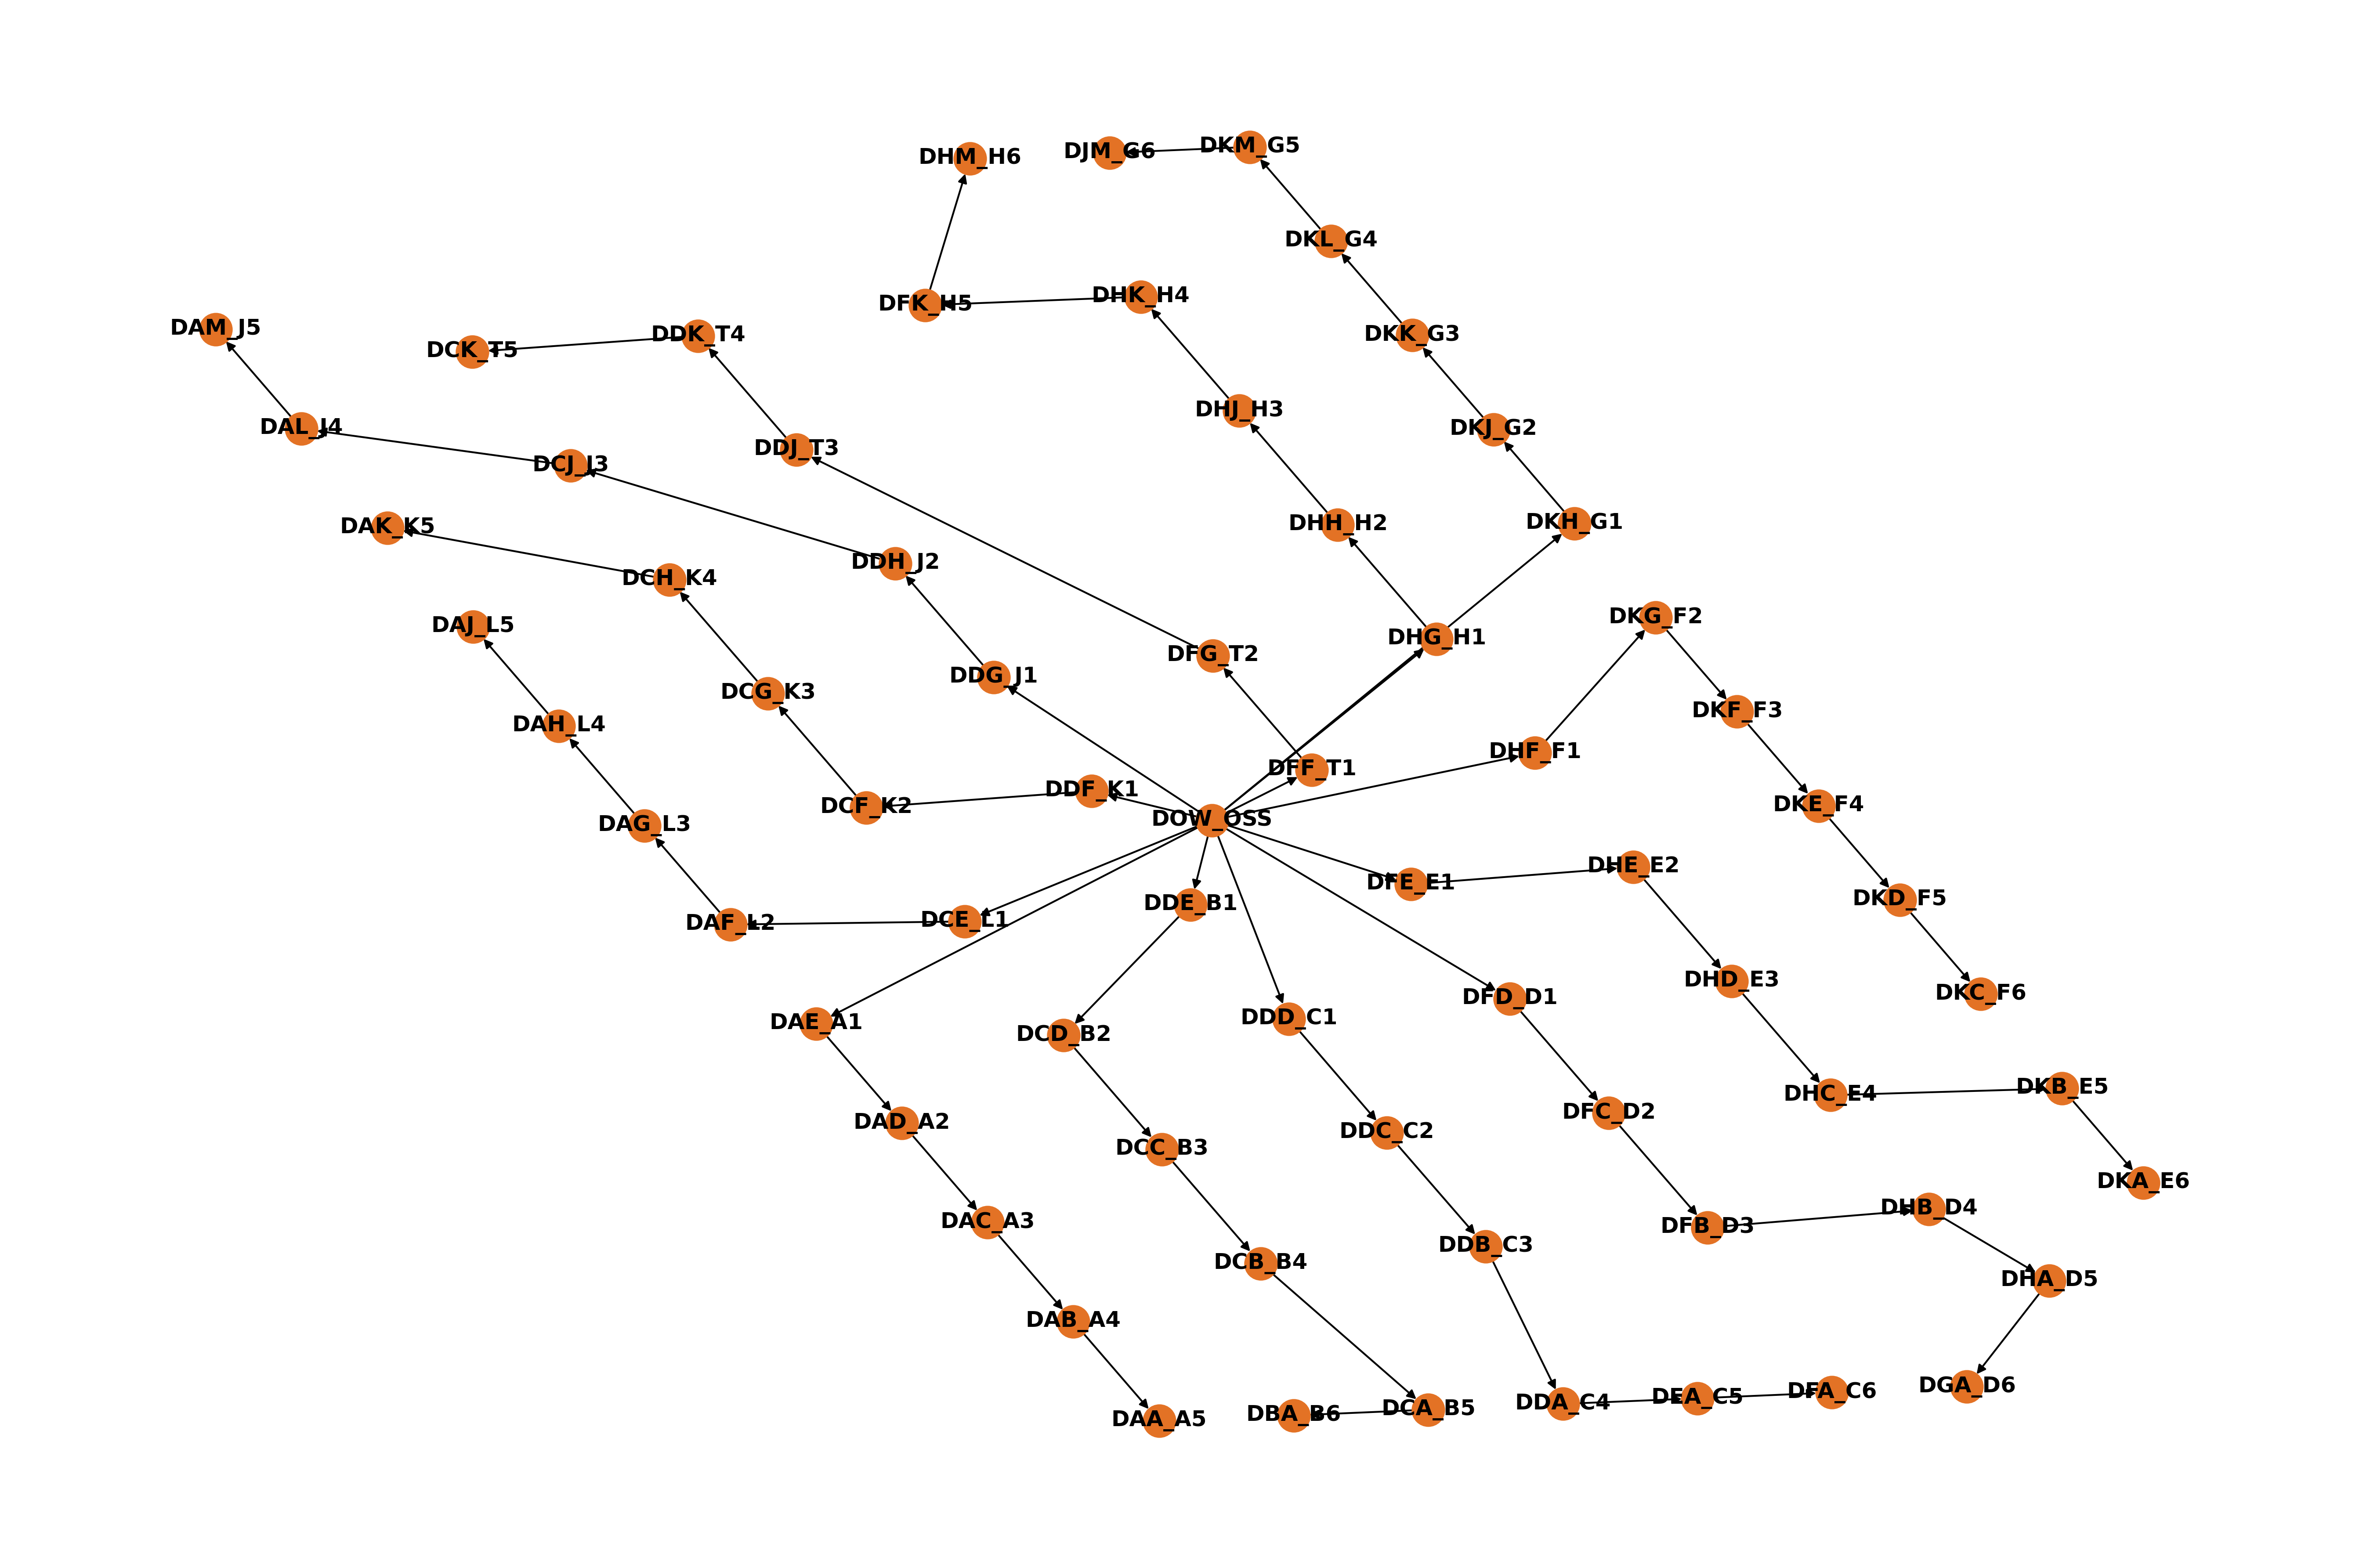

In [9]:
fig = plt.figure(figsize=(18, 12), dpi=300)
ax = fig.add_subplot(111)

env = WombatEnvironment(
    library_path,
    "weather_short.csv",
    simulation_name="plot_only",
    workday_start=8,
    workday_end=18,
)
manager = RepairManager(env)
windfarm = Windfarm(env, "offshore_dudgeon_array.csv", manager)

positions = {
    name: np.array([node["longitude"], node["latitude"]])
    for name, node in windfarm.graph.nodes(data=True)
}
nx.draw(
    windfarm.graph,
    with_labels=True,
    font_weight="bold",
    pos=positions,
    ax=ax,
    node_color="#E37225",
)

fig.tight_layout()
plt.savefig(
    os.path.join(library_path, "outputs/plots_and_tables/dudgeon_array_layout.png"),
    bbox_inches="tight",
)
plt.savefig(
    os.path.join(library_path, "outputs/plots_and_tables/dudgeon_array_layout.svg"),
    bbox_inches="tight",
)

In [10]:
def time_availability(turbine_availabiltiy: np.ndarray):
    """Computes the time-based availability of windfarm based on its turbines
    and substation operational ratios.
    """
    availability = turbine_availabiltiy > 0
    return availability.sum() / availability.size


def get_availability_data(operational_df: pd.DataFrame):
    """Computes the monthly time-based availability of a windfarm."""
    filter_cols = ["env_datetime", "env_time", "windfarm", "DOW_OSS", "year", "month"]
    turbine_cols = [col for col in operational_df.columns if col not in filter_cols]
    monthly_counts = operational_df.groupby(
        by=["year", "month"]
    ).count().windfarm * len(turbine_cols)

    substation_availability = operational_df["DOW_OSS"]
    turbine_availability = operational_df[turbine_cols]
    date_time = operational_df[["year", "month"]]
    hourly = (
        operational_df["DOW_OSS"].values.reshape((-1, 1))
        * operational_df[turbine_cols].values
    )
    monthly = [
        time_availability(hourly[(date_time.year == year) & (date_time.month == month)])
        for year, month in monthly_counts.index
    ]
    monthly_availability = pd.DataFrame(monthly_counts)
    monthly_availability.windfarm = monthly

    project_availability = time_availability(hourly)
    return monthly_availability, project_availability

## Offshore Availability

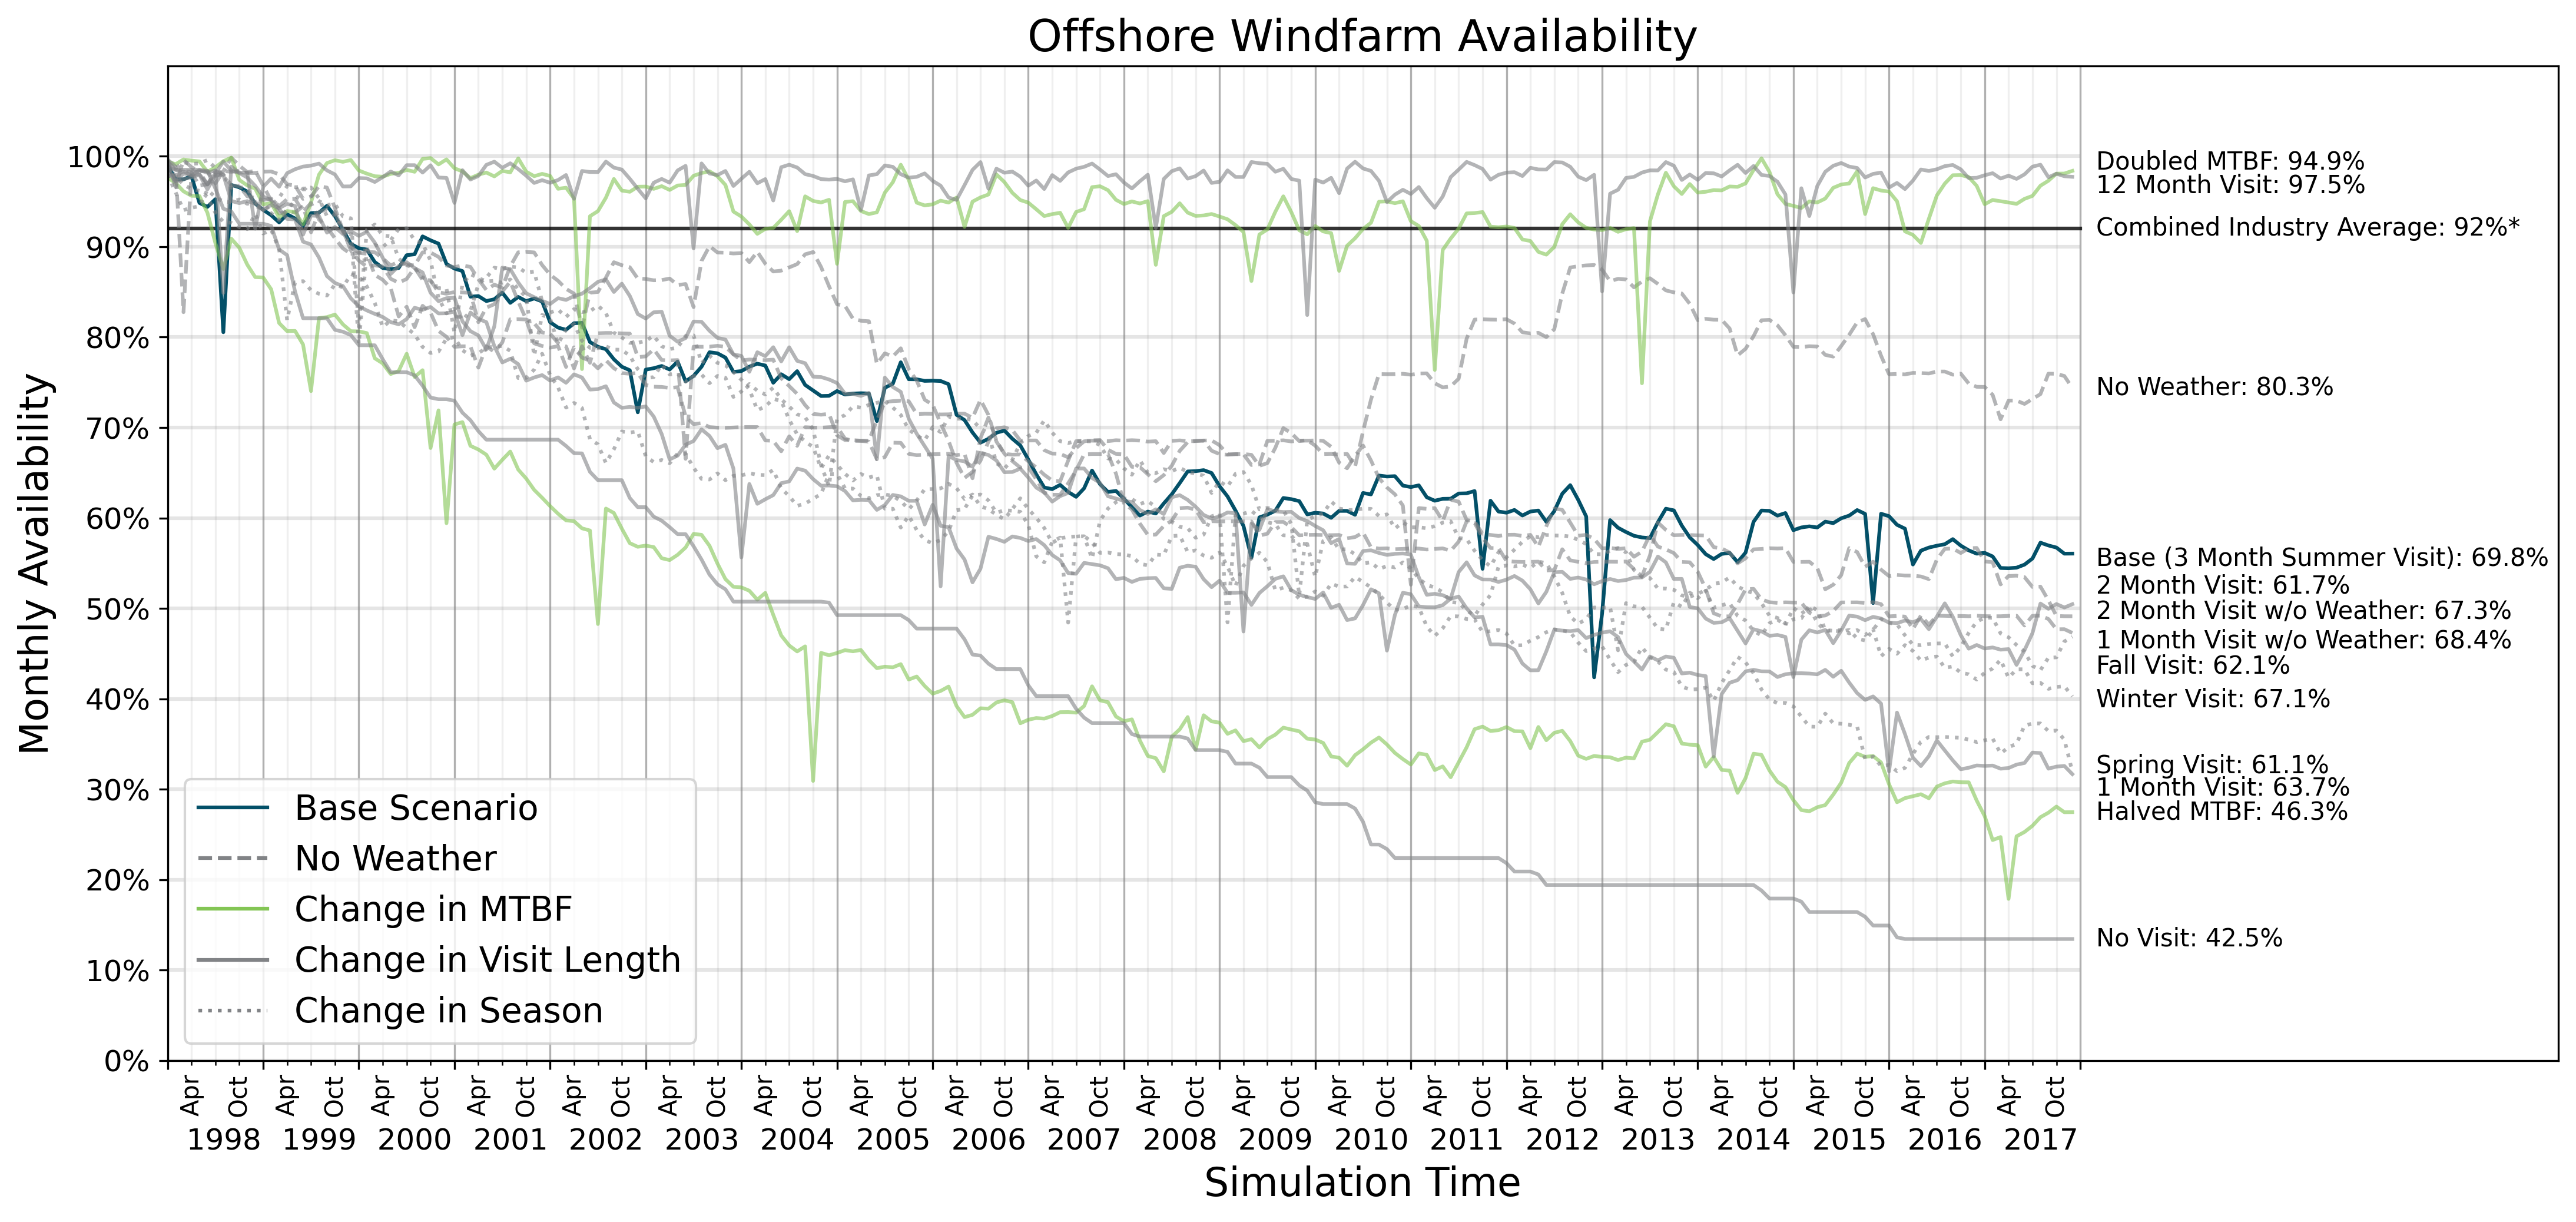

In [11]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=300)

line_legend = []
for formatting in format_categories:
    line = mlines.Line2D(
        [],
        [],
        color=formatting["color"],
        linestyle=formatting["linestyle"],
        label=formatting["name"],
    )
    line_legend.append(line)

ax.plot(np.arange(241), np.repeat(0.92, 241), alpha=0.8, color="black")
ax.text(242, 0.92, "Combined Industry Average: 92%*", va="center")

for scenario in data_frames:
    if scenario.startswith("onshore"):
        continue

    operations = data_frames[scenario]["operations"]
    monthly_availability, project_availability = get_availability_data(operations)
    data_frames[scenario]["monthly_availability"] = monthly_availability
    data_frames[scenario]["project_availability"] = project_availability

    fmt = format_dict[scenario]["format"]
    ax.plot(
        range(monthly_availability.shape[0]),
        monthly_availability.windfarm.values,
        color=fmt["color"],
        linestyle=fmt["linestyle"],
        alpha=fmt["alpha"],
    )

    name = format_dict[scenario]["name"]
    text = f"{name}: {project_availability * 100 :.1f}%"
    y = monthly_availability.loc[2017].loc[12].values[0]
    #     print(f"{name:>40}: {y:>4.2f}")
    if name == "Base (3 Month Summer Visit)":
        y *= 0.99
    elif name == "2 Month Visit w/o Weather":
        y *= 1.01
    elif name == "Fall Visit":
        y *= 0.93
    elif name == "1 Month Visit w/o Weather":
        y *= 0.98
    elif name == "2 Month Visit":
        y *= 1.04
    elif name == "Spring Visit":
        y *= 1.02
    elif name == "Winter Visit":
        y *= 0.99
    elif name == "1 Month Visit":
        y *= 0.95
    elif name == "12 Month Visit":
        y *= 0.99
    elif name == "Doubled MTBF":
        y *= 1.01
    ax.text(242, y, text, va="center")

xticks_major = [x * 12 for x in range(21)]
xticks_minor = list(range(0, 12 * 20, 3))
xlabels_major = [f"{year:>6}" for year in years]
xlabels_minor = ["Apr", "", "Oct"] + ["Apr", "", "Oct"] * 19
ax.set_xlabel("Simulation Time", fontsize=16)

ax.set_ylim(0, 1.1)
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_ylabel("Monthly Availability", fontsize=16)
ax.set_yticklabels([f"{y * 100:.0f}%" for y in ax.get_yticks()], fontsize=12)

ax.set_xlim(0, 300)
ax.set_xticks(xticks_major)
for t in ax.get_xticklabels():
    t.set_y(-0.05)
ax.set_xticks(xticks_minor, minor=True)
ax.set_xticklabels(xlabels_major, ha="left", fontsize=12)
ax.set_xticklabels(xlabels_minor, minor=True, rotation=90)

ax.set_title("Offshore Windfarm Availability", fontsize=18)
ax.legend(handles=line_legend, loc="lower left", fontsize=14)

plt.grid(axis="x", which="major")
plt.grid(alpha=0.2, which="minor")
ax.hlines(np.linspace(0, 1, 11), 0, 240, alpha=0.2, color="gray")

fig.tight_layout()
plt.savefig(
    os.path.join(library_path, "outputs/plots_and_tables/offshore_availability.png"),
    bbox_to_inches="tight",
)
plt.savefig(
    os.path.join(library_path, "outputs/plots_and_tables/offshore_availability.svg"),
    bbox_to_inches="tight",
)

## Onshore Availability

             Base (3 Month Summer Visit): 0.76
                              No Weather: 0.85
                            Doubled MTBF: 1.00
                             Halved MTBF: 0.28
                          12 Month Visit: 0.99
                                No Visit: 0.18
                           2 Month Visit: 0.61
               2 Month Visit w/o Weather: 0.64
                           1 Month Visit: 0.49
               1 Month Visit w/o Weather: 0.46
                              Fall Visit: 0.78
                            Winter Visit: 0.70
                            Spring Visit: 0.73


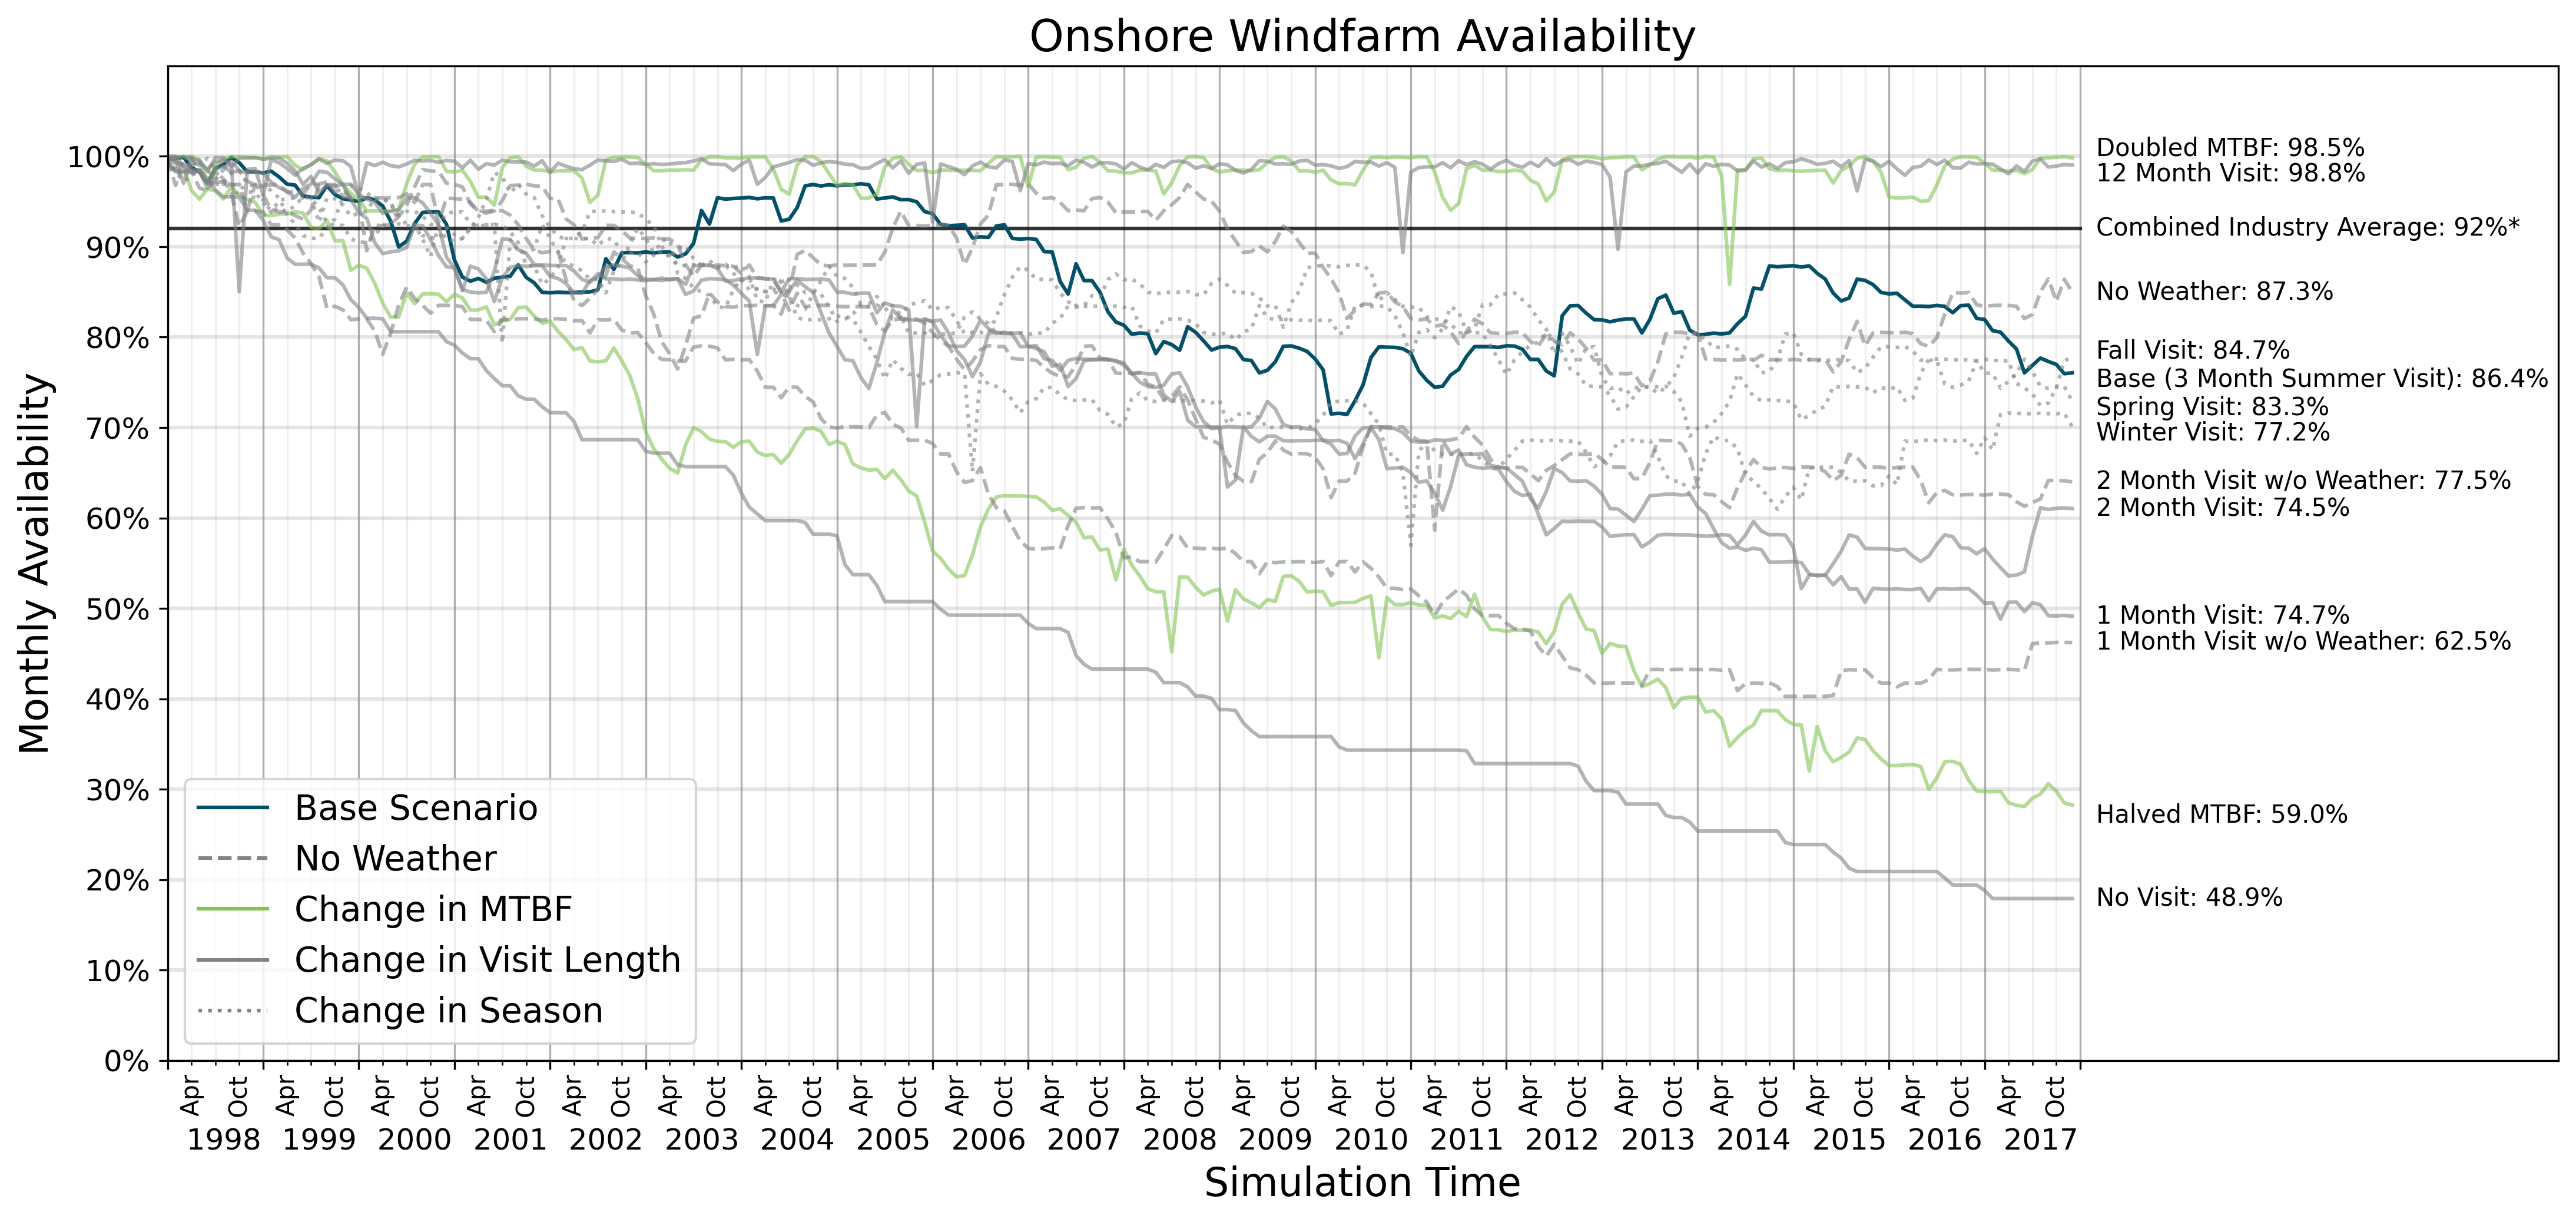

In [12]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=300)

line_legend = []
for formatting in format_categories:
    line = mlines.Line2D(
        [],
        [],
        color=formatting["color"],
        linestyle=formatting["linestyle"],
        label=formatting["name"],
    )
    line_legend.append(line)

ax.plot(np.arange(241), np.repeat(0.92, 241), alpha=0.8, color="black")
ax.text(242, 0.92, "Combined Industry Average: 92%*", va="center")

for scenario in data_frames:
    if scenario.startswith("offshore") or scenario.endswith("v2"):
        continue

    operations = data_frames[scenario]["operations"]
    monthly_availability, project_availability = get_availability_data(operations)
    data_frames[scenario]["monthly_availability"] = monthly_availability
    data_frames[scenario]["project_availability"] = project_availability

    fmt = format_dict[scenario]["format"]
    ax.plot(
        range(monthly_availability.shape[0]),
        monthly_availability.windfarm.values,
        color=fmt["color"],
        linestyle=fmt["linestyle"],
        alpha=fmt["alpha"],
    )

    name = format_dict[scenario]["name"]
    text = f"{name}: {project_availability * 100 :.1f}%"
    y = monthly_availability.loc[2017].loc[12].values[0]
    print(f"{name:>40}: {y:>4.2f}")
    if name == "Base (3 Month Summer Visit)":
        y *= 0.99
    elif name == "Fall Visit":
        y *= 1.01
    # #     elif name == "No Weather":
    # #         y *= 0.98
    elif name == "Doubled MTBF":
        y *= 1.01
    elif name == "12 Month Visit":
        y *= 0.99
    #     elif name == "1 Month Visit w/o Weather":
    #         y *= 1.01
    elif name == "Spring Visit":
        y *= 0.99
    elif name == "Halved MTBF":
        y *= 0.96
    elif name == "Winter Visit":
        y *= 0.99
    #     elif name == "2 Month Visit w/o Weather":
    #         y *= 0.96
    #     elif name == "1 Month Visit":
    #         y *= 0.99
    ax.text(242, y, f"{text}", va="center")

xticks_major = [x * 12 for x in range(21)]
xticks_minor = list(range(0, 12 * 20, 3))
xlabels_major = [f"{year:>6}" for year in years]
xlabels_minor = ["Apr", "", "Oct"] + ["Apr", "", "Oct"] * 19
ax.set_xlabel("Simulation Time", fontsize=16)

ax.set_ylim(0, 1.1)
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_ylabel("Monthly Availability", fontsize=16)
ax.set_yticklabels([f"{y * 100:.0f}%" for y in ax.get_yticks()], fontsize=12)

ax.set_xlim(0, 300)
ax.set_xticks(xticks_major)
for t in ax.get_xticklabels():
    t.set_y(-0.05)
ax.set_xticks(xticks_minor, minor=True)
ax.set_xticklabels(xlabels_major, ha="left", fontsize=12)
ax.set_xticklabels(xlabels_minor, minor=True, rotation=90)

ax.set_title("Onshore Windfarm Availability", fontsize=18)
ax.legend(handles=line_legend, loc="lower left", fontsize=14)

plt.grid(axis="x", which="major")
plt.grid(alpha=0.2, which="minor")
ax.hlines(np.linspace(0, 1, 11), 0, 240, alpha=0.2, color="gray")
fig.tight_layout()
plt.savefig(
    os.path.join(library_path, "outputs/plots_and_tables/onshore_availability.png"),
    bbox_to_inches="tight",
)
plt.savefig(
    os.path.join(library_path, "outputs/plots_and_tables/onshore_availability.svg"),
    bbox_to_inches="tight",
)

## Offshore Cost Comparison

In [13]:
fig = plt.figure(figsize=(16, 12), dpi=300)
axes = fig.subplots(
    3,
    4,
    sharey=True,
    subplot_kw=dict(ylim=(0, 200000), yticks=range(0, 200001, 20000)),
    gridspec_kw=dict(wspace=0.05, hspace=0.05),
)

x = range(len(cost_columns))
x_labels = [cost_format_dict[x]["name"] for x in cost_columns]
major_cat_colors = [cost_format_dict[x]["color"] for x in cost_columns]
offshore_equipment_colors = [cost_format_dict[e]["color"] for e in offshore_equipment]

patches = []
for name, color in [
    *zip(x_labels[:-2], major_cat_colors[:-2]),
    *reversed(list(zip(offshore_equipment, offshore_equipment_colors))),
    (x_labels[-1], major_cat_colors[-1]),
]:
    name = cost_format_dict[name]["name"] if name in offshore_equipment else name
    patch = mpatches.Patch(color=color, label=name)
    patches.append(patch)

scenario = "offshore_base_3_month_summer"
base_costs = costs = (
    data_frames[scenario]["events"][cost_columns].sum(axis=0)
    / offshore_total_mw
    / len(years)
)
base_availability = data_frames[scenario]["project_availability"]

_data_frames = {
    name: values
    for name, values in data_frames.items()
    if name.startswith("offshore") and name != "offshore_0_month"
}
for scenario, ax in zip(_data_frames, axes.flatten()):
    name = format_dict[scenario]["name"]
    events = data_frames[scenario]["events"]

    costs = events[cost_columns].sum(axis=0)
    annual_mw_costs = costs / offshore_total_mw / len(years)
    availability = data_frames[scenario]["project_availability"]

    vals = annual_mw_costs.copy()
    vals.loc["equipment_cost"] = 0

    equip_ix = cost_columns.index("equipment_cost")
    offshore_equipment_costs = (
        events[events.equipment_cost > 0].groupby("agent").sum().equipment_cost
        / offshore_total_mw
        / len(years)
    )

    bottom = np.zeros(annual_mw_costs.size)
    for i, e in enumerate(offshore_equipment):
        _colors = deepcopy(major_cat_colors)
        _colors[equip_ix] = cost_format_dict[e]["color"]
        y = vals.values
        if i > 0:
            y = np.zeros(vals.size)
        try:
            y[equip_ix] = offshore_equipment_costs.loc[e]
            ax.bar(x, y, color=_colors, bottom=bottom)
        except KeyError:
            pass
        bottom += y

    if scenario != "offshore_base_3_month_summer":
        cost_diff = (annual_mw_costs.values - base_costs.values) / base_costs.values
        cost_diff_text = [f"{'+' if d > 0 else ''}{d * 100:.1f}%" for d in cost_diff]
        for i, (y, text) in enumerate(zip(bottom, cost_diff_text)):
            ax.text(i, y + 2000, text, ha="center")

        availability_diff = (availability - base_availability) / base_availability
        availability_diff_text = f"Availability {'+' if availability_diff > 0 else ''}{availability_diff * 100:.1f}%"
        ax.text(-0.5, 130000, availability_diff_text, ha="left", va="center")
    else:
        cost_text = [f"${cost:,.0f}" for cost in base_costs]
        for i, (y, text) in enumerate(zip(base_costs, cost_text)):
            ax.text(i, y + 2000, text, ha="center")

        text = f"Availability: {base_availability * 100:.1f}%"
        ax.text(-0.5, 130000, text, ha="left", va="center")

    ax.text(1.5, 190000, name, fontsize=13, ha="center", va="center")

    ax.set_yticklabels([f"{y:,.0f}" for y in ax.get_yticks()])
    ax.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)

    ax.grid(axis="y", alpha=0.5)
    ax.set_axisbelow(True)

# axes[0, 1].set_title(
#     "Operations and Maintenance Cost Breakdown by Category",
#     fontsize=20, x=1.1, y=1.05, ha="center"
# )
axes[0, 1].legend(
    handles=patches, loc="upper right", ncol=6, fontsize=12, bbox_to_anchor=(2.5, 1.15)
)
axes[1, 0].set_ylabel(
    "Annualized Cost per MW (USD/MW/year)",
    fontsize=14,
    x=-0.2,
    y=0.5,
    ha="center",
    va="bottom",
)
axes[2, 1].set_xlabel(
    "Cost Category",
    fontsize=14,
    x=1.05,
    ha="center",
    va="top",
)

for ax in axes[:, 1:].flatten():
    ax.tick_params(
        axis="y",
        which="both",
        left=False,
        right=False,
        labelleft=False,
        labelright=False,
    )

# axes.flatten()[-1].legend(handles=patches, loc="center", fontsize=16)
# axes.flatten()[-1].tick_params(axis="both", which="both", bottom=False, top=False, left=False, right=False, labelbottom=False, grid_alpha=0)
# axes.flatten()[-1].axis('off')

fig.tight_layout()
plt.savefig(
    os.path.join(library_path, "outputs/plots_and_tables/offshore_costs.png"),
    bbox_inches="tight",
)
plt.savefig(
    os.path.join(library_path, "outputs/plots_and_tables/offshore_costs.svg"),
    bbox_inches="tight",
)

/opt/miniconda3/envs/wombat/lib/python3.7/site-packages/ipykernel_launcher.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


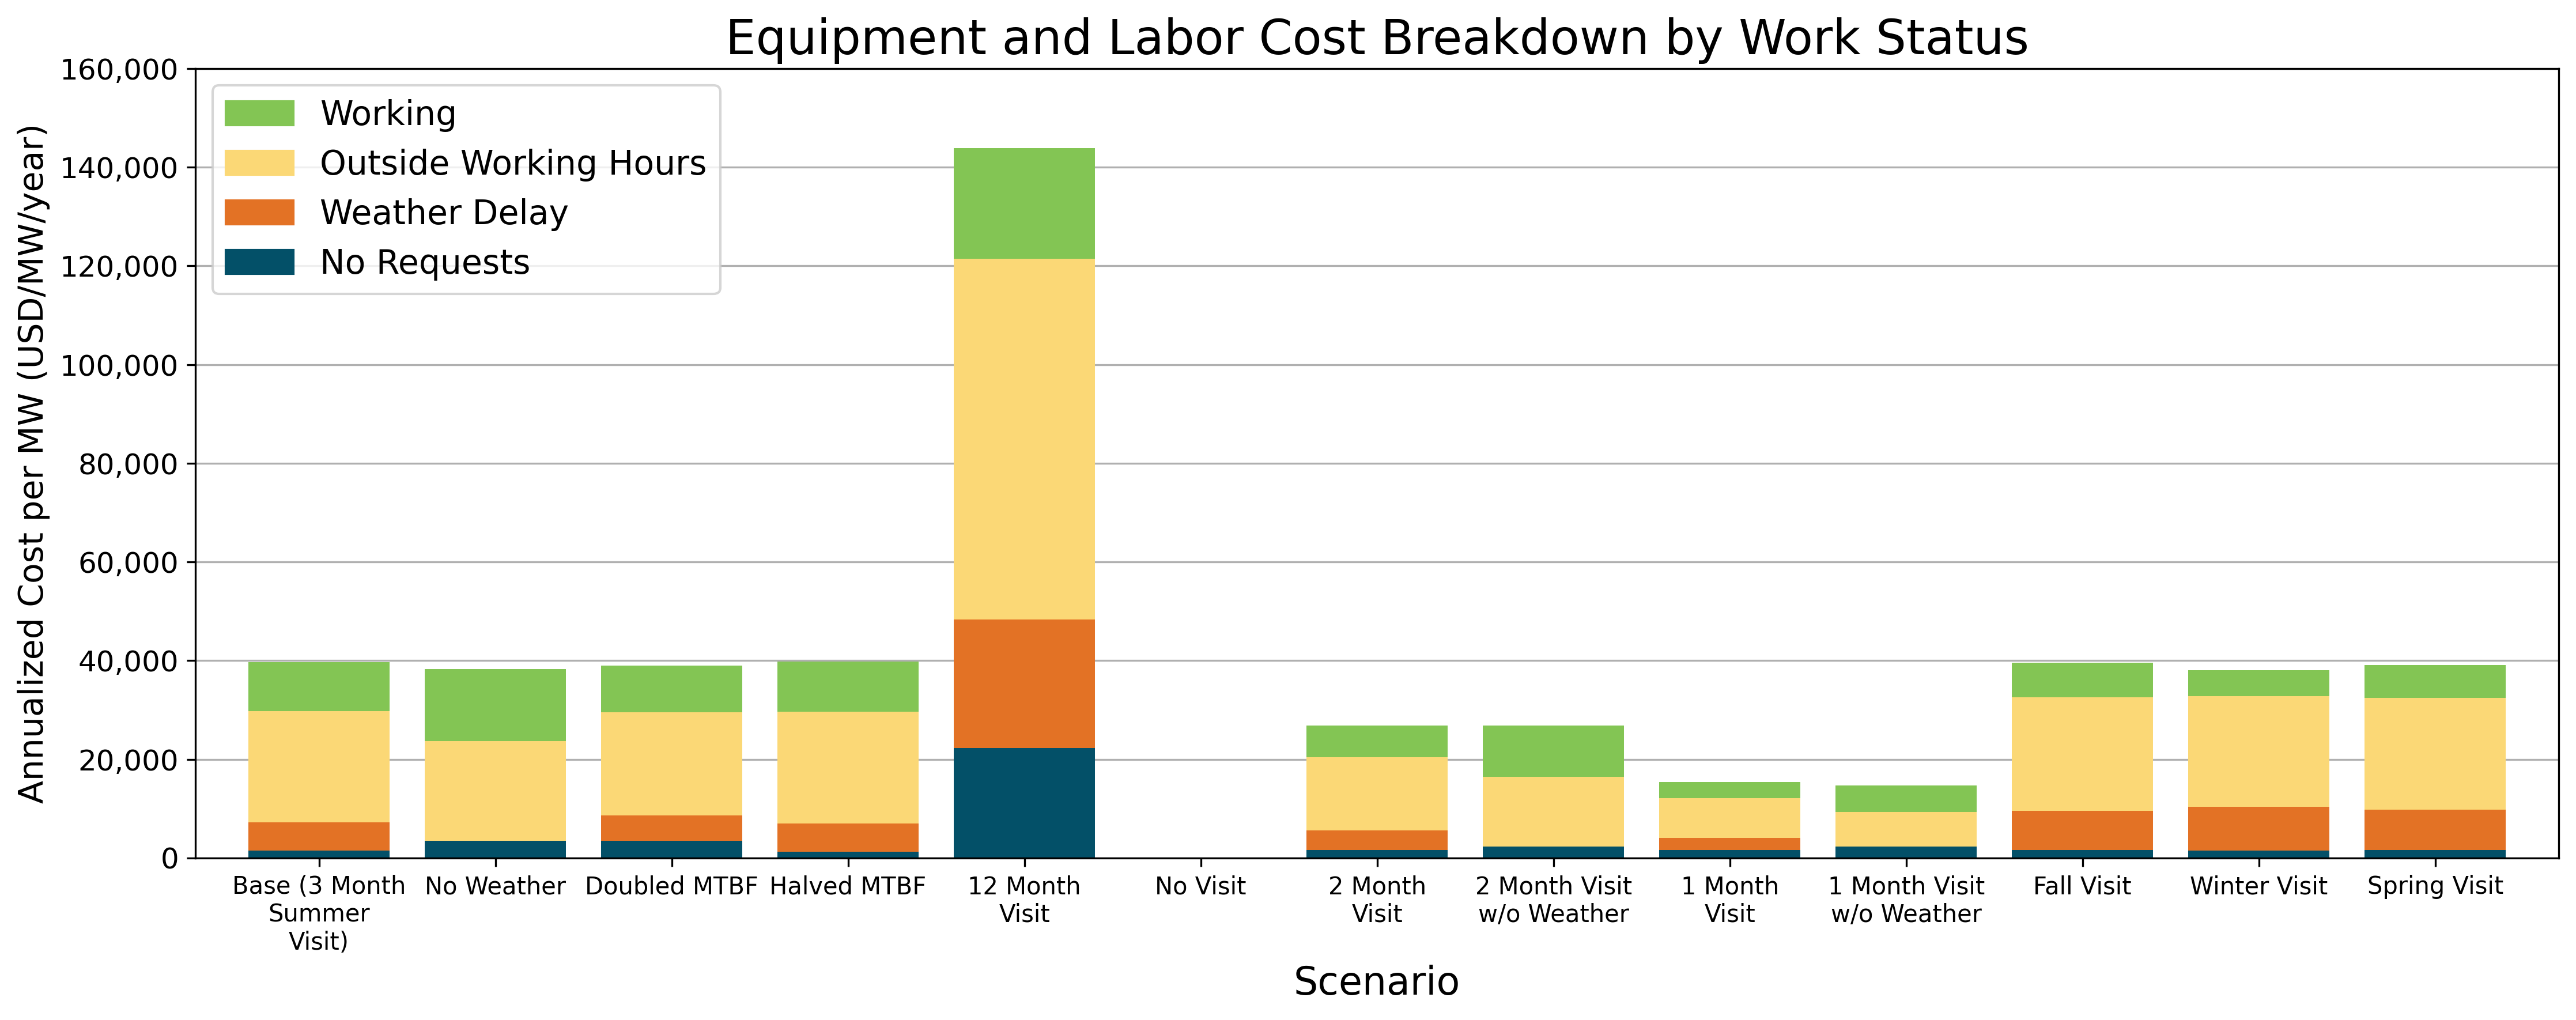

In [14]:
fig = plt.figure(figsize=(15, 6), dpi=300)
ax = fig.add_subplot(111)

colors = ["#035068", "#E37225", "#FBD876", "#83C554"]
indices = ["No Requests", "Weather Delay", "Outside Working Hours", "Working"]
_data_frames = {
    name: values for name, values in data_frames.items() if name.startswith("offshore")
}
x_tick_labels = [format_dict[s]["name"] for s in _data_frames]
y_ticks = range(0, 160001, 20000)

scenario = "offshore_base_3_month_summer"
name = format_dict[scenario]["name"]
# events = data_frames[scenario]["events"]
# equip_labor = equipment_labor_cost_breakdown(events, equipment, offshore_total_mw, 20).values

patches = []
for name, color in zip(indices, colors):
    patch = mpatches.Patch(color=color, label=name)
    patches.append(patch)

for i, scenario in enumerate(_data_frames):
    if all(s is None for s in scenarios[scenario][2:]):
        continue
    name = format_dict[scenario]["name"]
    events = data_frames[scenario]["events"]
    equip_labor = equipment_labor_cost_breakdown(
        events, offshore_equipment, offshore_total_mw, 20
    )

    bottom = 0
    for c, ix in zip(colors, indices):
        if ix not in equip_labor.index:
            continue
        ax.bar(i, equip_labor.loc[ix], bottom=bottom, color=c)
        bottom += equip_labor.loc[ix]

ax.set_xticks(range(len(x_tick_labels)))
ax.set_xticklabels(
    [make_label_multi_lines(x, longest_line_length=12) for x in x_tick_labels],
    fontsize=10,
)
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{y:,.0f}" for y in y_ticks], fontsize=12)

ax.set_title("Equipment and Labor Cost Breakdown by Work Status", fontsize=20)
ax.set_xlabel("Scenario", fontsize=16)
ax.set_ylabel("Annualized Cost per MW (USD/MW/year)", fontsize=14)

ax.set_xlim(-0.7, 12.7)
ax.legend(handles=list(reversed(patches)), ncol=1, fontsize=14, loc="upper left")

ax.grid(axis="y")
ax.set_axisbelow(True)

fig.tight_layout()
plt.savefig(
    os.path.join(
        library_path, "outputs/plots_and_tables/offshore_equipment_labor_breakdown.png"
    ),
    bbox_inches="tight",
)
plt.savefig(
    os.path.join(
        library_path, "outputs/plots_and_tables/offshore_equipment_labor_breakdown.svg"
    ),
    bbox_inches="tight",
)

In [15]:
availability, annual_mw_costs

(0.6108963226305162,
 total_labor_cost     1348.413246
 materials_cost      12502.701493
 equipment_cost      37780.141791
 total_cost          51631.256530
 dtype: float64)

## Offshore Cost vs Availability Comparison

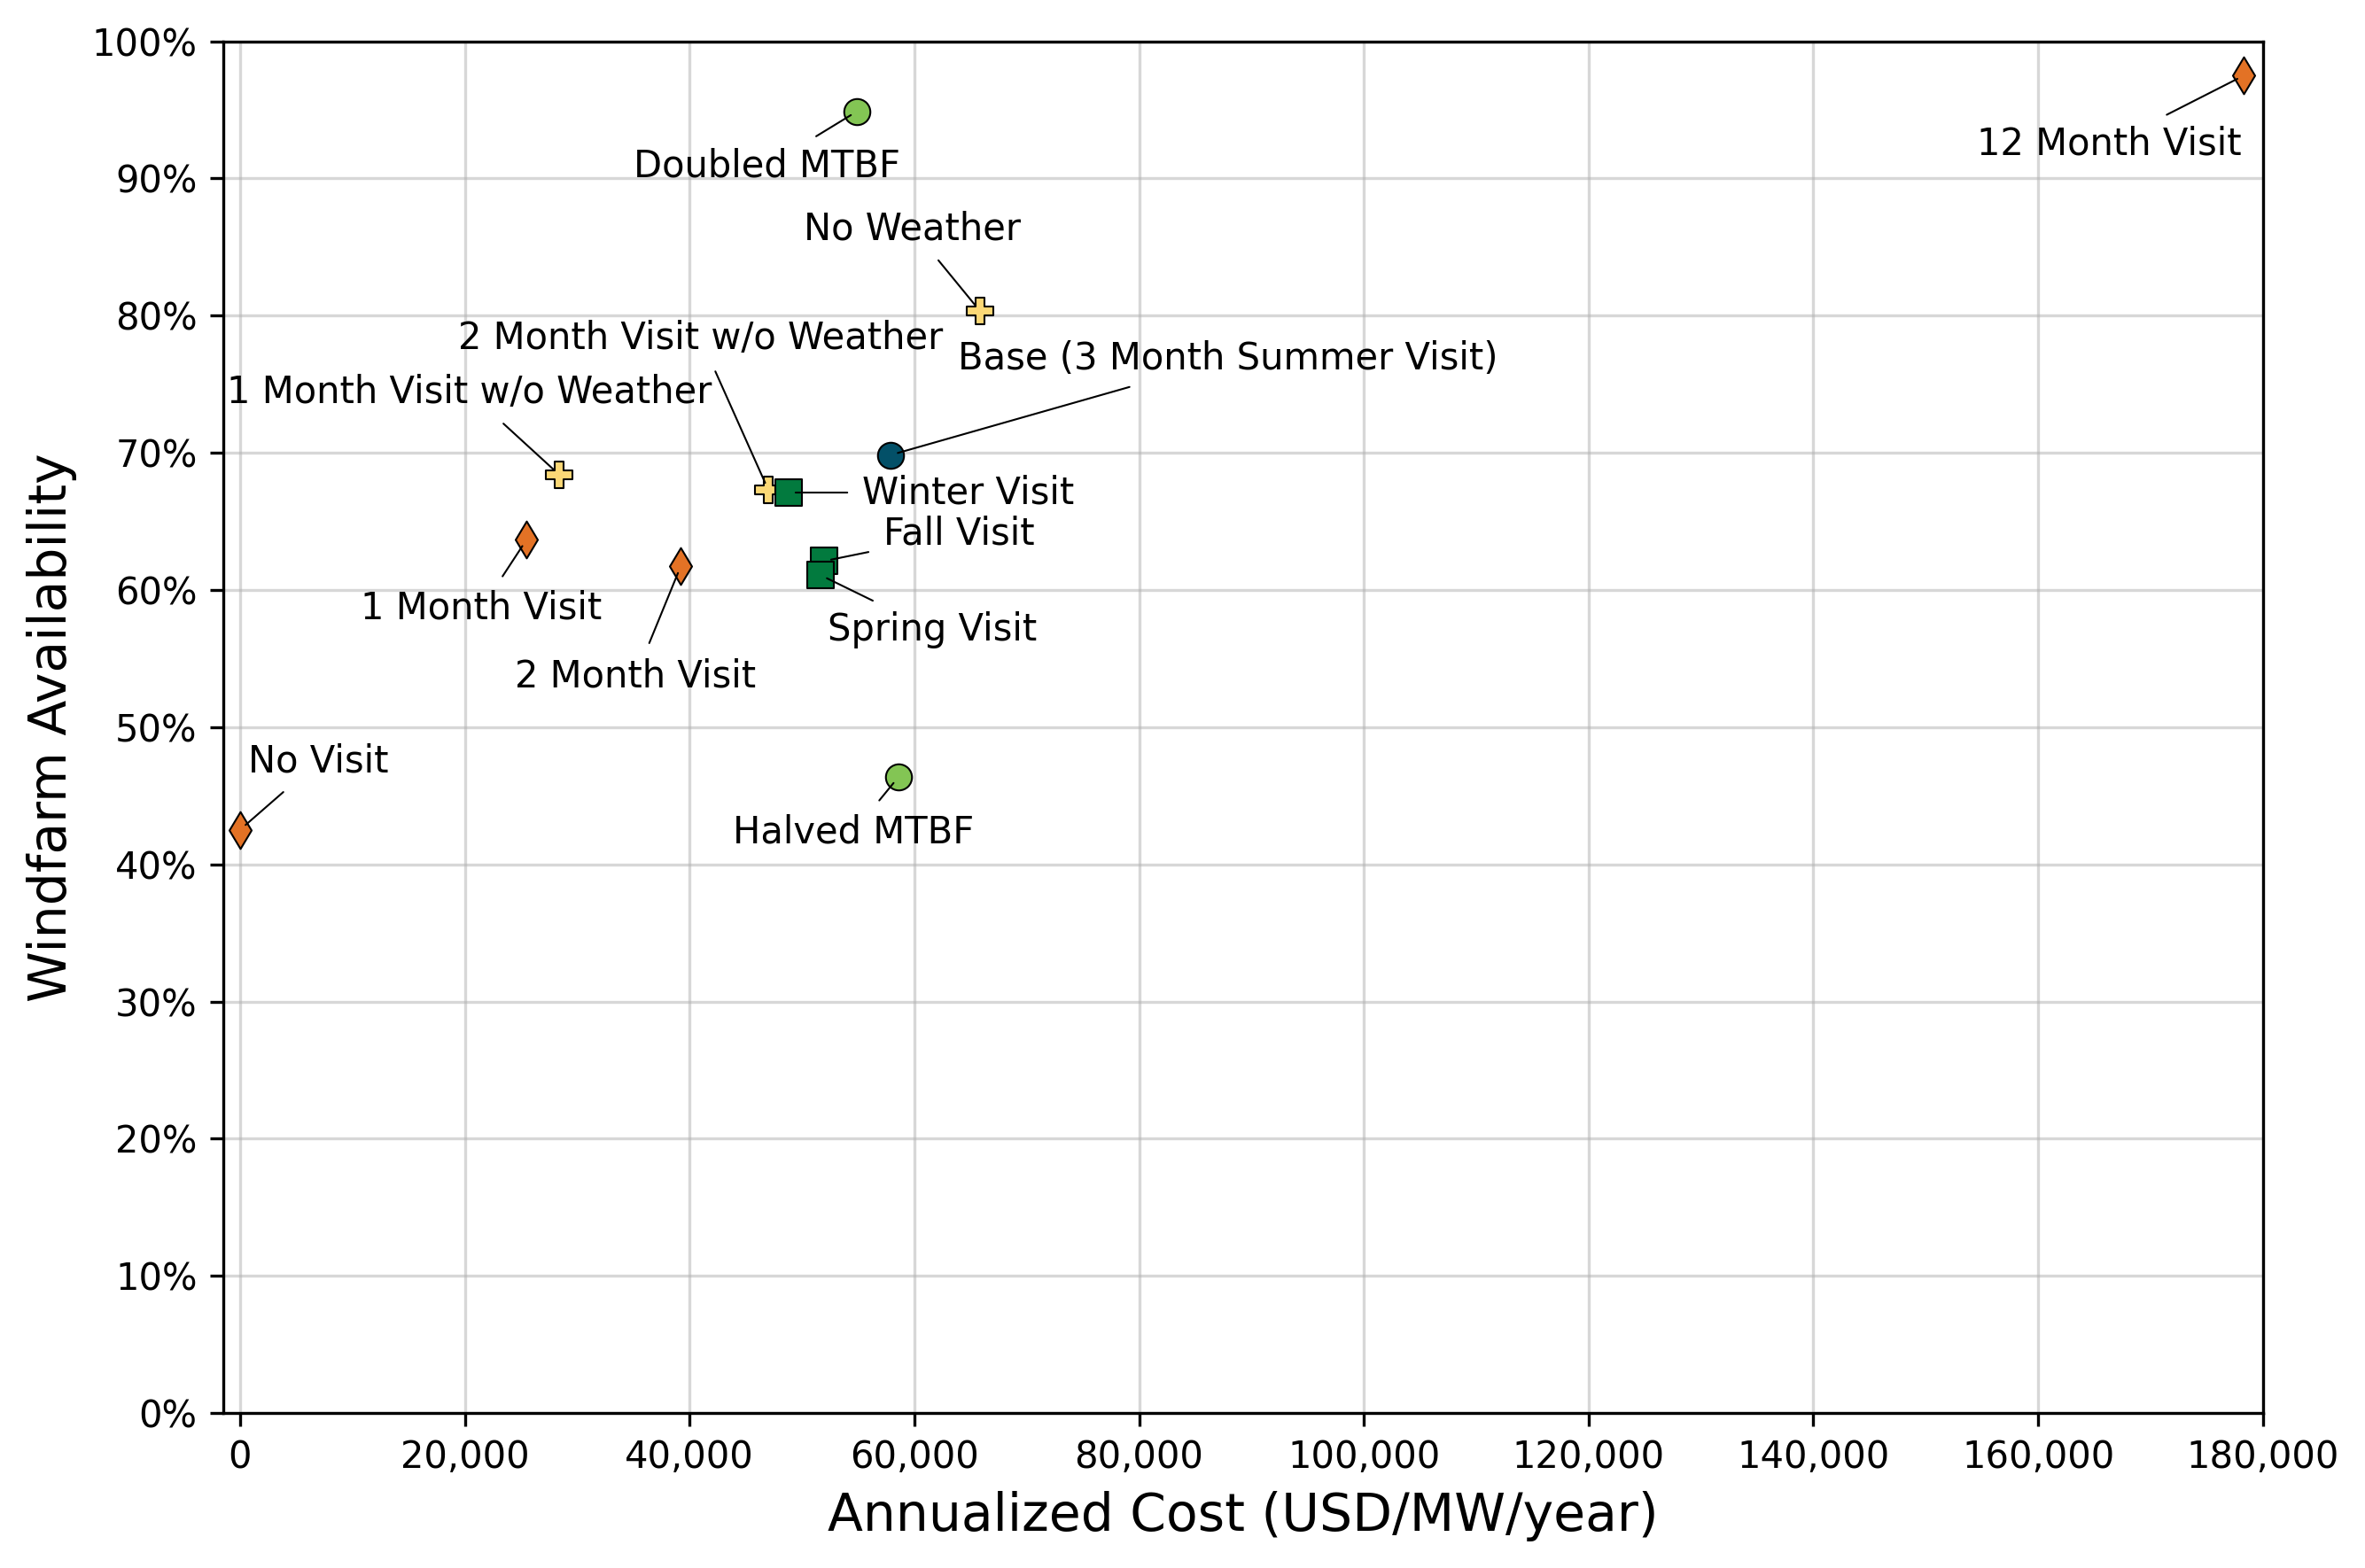

In [16]:
fig = plt.figure(figsize=(9, 6), dpi=300)
ax = fig.add_subplot(111)

x_ticks = range(0, 180001, 20000)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f"{x:,.0f}" for x in x_ticks])

y_ticks = range(0, 101, 10)
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{y:.0f}%" for y in y_ticks])

ax.grid(alpha=0.5)
ax.set_axisbelow(True)

ax.set_xlim(-1500, 180000)
ax.set_ylim(0, 100)

ax.set_xlabel("Annualized Cost (USD/MW/year)", fontsize=14)
ax.set_ylabel("Windfarm Availability", fontsize=14)

arrow_props = arrowprops = dict(arrowstyle="-", linewidth=0.5, zorder=0)

_data_frames = {
    name: values for name, values in data_frames.items() if name.startswith("offshore")
}
for scenario in _data_frames:
    name = format_dict[scenario]["name"]
    events = data_frames[scenario]["events"]
    fmt = format_dict[scenario]["format"]
    annual_mw_costs = data_frames[scenario]["events"].total_cost.sum()
    annual_mw_costs = annual_mw_costs / offshore_total_mw / len(years)
    availability = data_frames[scenario]["project_availability"] * 100
    text_positions = (annual_mw_costs, availability)
    if name == "No Visit":
        text_positions = (annual_mw_costs + 7000, availability + 5)
    elif name == "12 Month Visit":
        text_positions = (annual_mw_costs - 12000, availability - 5)
    elif name == "Doubled MTBF":
        text_positions = (annual_mw_costs - 8000, availability - 4)
    elif name == "No Weather":
        text_positions = (annual_mw_costs - 6000, availability + 6)
    elif name == "Halved MTBF":
        text_positions = (annual_mw_costs - 4000, availability - 4)
    elif name == "2 Month Visit":
        text_positions = (annual_mw_costs - 4000, availability - 8)
    elif name == "1 Month Visit":
        text_positions = (annual_mw_costs - 4000, availability - 5)
    elif name == "2 Month Visit w/o Weather":
        text_positions = (annual_mw_costs - 6000, availability + 11)
    elif name == "1 Month Visit w/o Weather":
        text_positions = (annual_mw_costs - 8000, availability + 6)
    elif name == "Fall Visit":
        text_positions = (annual_mw_costs + 12000, availability + 2)
    elif name == "Spring Visit":
        text_positions = (annual_mw_costs + 10000, availability - 4)
    elif name == "Winter Visit":
        text_positions = (annual_mw_costs + 16000, availability)
    elif name == "Base (3 Month Summer Visit)":
        text_positions = (annual_mw_costs + 30000, availability + 7)

    ax.scatter(
        annual_mw_costs,
        availability,
        s=50,
        color=fmt["marker_color"],
        marker=fmt["marker"],
        edgecolor="black",
        linewidth=0.5,
    )
    ax.annotate(
        name,
        (annual_mw_costs, availability),
        xytext=text_positions,
        xycoords="data",
        ha="center",
        va="center",
        fontsize=10,
        arrowprops=arrow_props,
    )

fig.tight_layout()
plt.savefig(
    os.path.join(
        library_path, "outputs/plots_and_tables/offshore_cost_availability.png"
    ),
    bbox_to_inches="tight",
)
plt.savefig(
    os.path.join(
        library_path, "outputs/plots_and_tables/offshore_cost_availability.svg"
    ),
    bbox_to_inches="tight",
)

In [17]:
(
    events.groupby("part_name").sum()[["total_cost", "materials_cost"]]
    / offshore_total_mw
    / 20
).sort_values(["total_cost"], ascending=False)

total_cost  materials_cost
part_name                                         
array cable           21803.480535     5194.029851
gearbox               15305.581887     3109.328358
supporting_structure   3908.315283     2300.611940
yaw_system             2977.712158      675.223881
rotor_blades           1400.956048      530.283582
electronic_control     1381.446315      138.246269
sensors                1291.182603      133.007463
electrical_system       579.375435       66.067164
generator               433.470958      152.410448
mechanical_brake        410.005379       99.246269
rotor_hub               311.365376       67.910448
hydraulic_system         83.117289        6.985075
transformer              35.767102       27.119403
drive_train              29.053327        2.231343

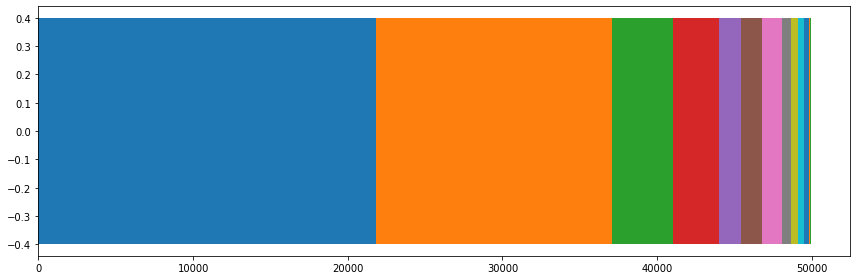

In [18]:
data = events.groupby("part_name").sum()[["total_cost", "materials_cost"]]
data = data / offshore_total_mw / 20
data = data.sort_values(["total_cost"], ascending=False)

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111)

bottom = 0
for part in data.index.values:
    ax.barh(0, data.loc[part, "total_cost"], left=bottom)
    bottom += data.loc[part, "total_cost"]

fig.tight_layout()

## Onshore Cost Comparison

/opt/miniconda3/envs/wombat/lib/python3.7/site-packages/ipykernel_launcher.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


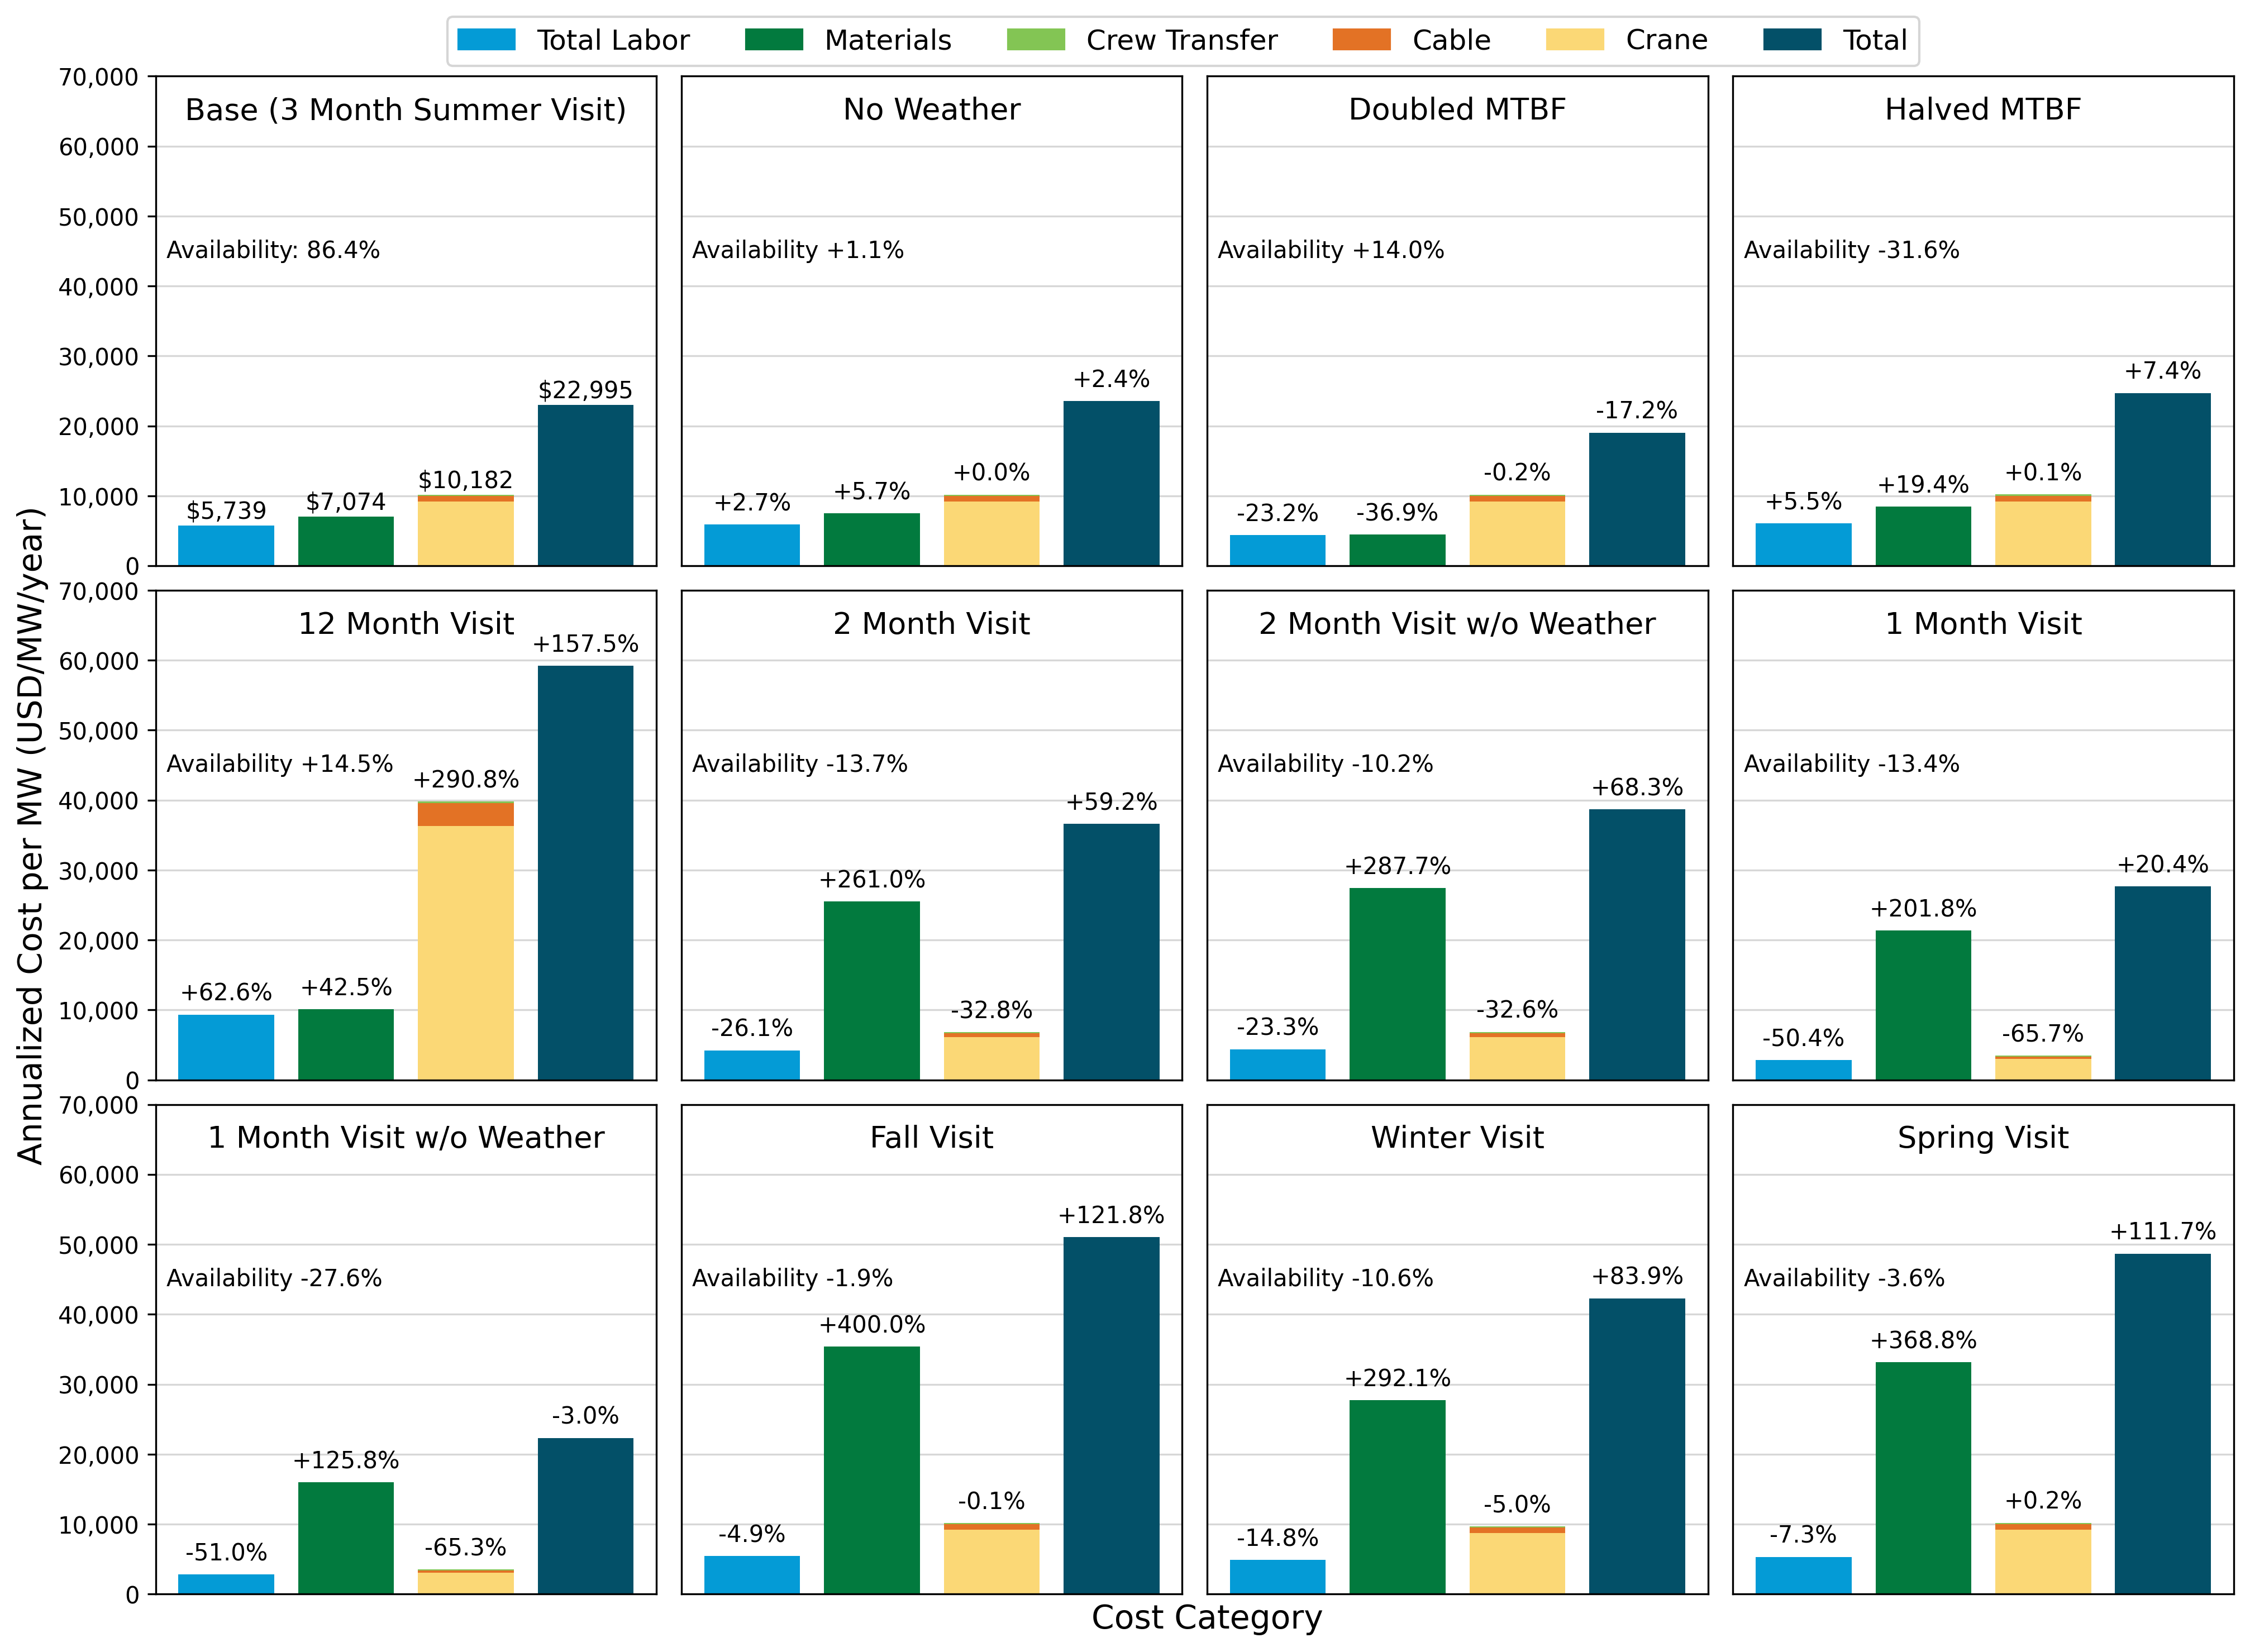

In [19]:
fig = plt.figure(figsize=(16, 12), dpi=300)
axes = fig.subplots(
    3,
    4,
    sharey=True,
    subplot_kw=dict(ylim=(0, 70000), yticks=range(0, 70001, 10000)),
    gridspec_kw=dict(wspace=0.05, hspace=0.05),
)

x = range(len(cost_columns))
x_labels = [cost_format_dict[x]["name"] for x in cost_columns]
major_cat_colors = [cost_format_dict[x]["color"] for x in cost_columns]
onshore_equipment_colors = [cost_format_dict[e]["color"] for e in onshore_equipment]

patches = []
for name, color in [
    *zip(x_labels[:-2], major_cat_colors[:-2]),
    *reversed(list(zip(onshore_equipment, onshore_equipment_colors))),
    (x_labels[-1], major_cat_colors[-1]),
]:
    name = cost_format_dict[name]["name"] if name in onshore_equipment else name
    patch = mpatches.Patch(color=color, label=name)
    patches.append(patch)

scenario = "onshore_base_3_month_summer"
base_costs = costs = (
    data_frames[scenario]["events"][cost_columns].sum(axis=0)
    / onshore_total_mw
    / len(years)
)
base_availability = data_frames[scenario]["project_availability"]

_data_frames = {
    name: values
    for name, values in data_frames.items()
    if name.startswith("onshore") and name != "onshore_0_month"
}
for scenario, ax in zip(_data_frames, axes.flatten()):
    name = format_dict[scenario]["name"]
    events = data_frames[scenario]["events"]

    costs = events[cost_columns].sum(axis=0)
    annual_mw_costs = costs / onshore_total_mw / len(years)
    availability = data_frames[scenario]["project_availability"]

    vals = annual_mw_costs.copy()
    vals.loc["equipment_cost"] = 0

    equip_ix = cost_columns.index("equipment_cost")
    onshore_equipment_costs = (
        events[events.equipment_cost > 0].groupby("agent").sum().equipment_cost
        / onshore_total_mw
        / len(years)
    )

    bottom = np.zeros(annual_mw_costs.size)
    for i, e in enumerate(onshore_equipment):
        _colors = deepcopy(major_cat_colors)
        _colors[equip_ix] = cost_format_dict[e]["color"]
        y = vals.values
        if i > 0:
            y = np.zeros(vals.size)
        try:
            y[equip_ix] = onshore_equipment_costs.loc[e]
            ax.bar(x, y, color=_colors, bottom=bottom)
        except KeyError:
            pass
        bottom += y

    if scenario != "onshore_base_3_month_summer":
        cost_diff = (annual_mw_costs.values - base_costs.values) / base_costs.values
        cost_diff_text = [f"{'+' if d > 0 else ''}{d * 100:.1f}%" for d in cost_diff]
        for i, (y, text) in enumerate(zip(bottom, cost_diff_text)):
            ax.text(i, y + 2000, text, ha="center")

        availability_diff = (availability - base_availability) / base_availability
        availability_diff_text = f"Availability {'+' if availability_diff > 0 else ''}{availability_diff * 100:.1f}%"
        ax.text(-0.5, 45000, availability_diff_text, ha="left", va="center")
    else:
        cost_text = [f"${cost:,.0f}" for cost in base_costs]
        for i, (y, text) in enumerate(zip(base_costs, cost_text)):
            ax.text(i, y + 1000, text, ha="center")

        text = f"Availability: {base_availability * 100:.1f}%"
        ax.text(-0.5, 45000, text, ha="left", va="center")

    ax.text(1.5, 65000, name, fontsize=13, ha="center", va="center")

    ax.set_yticklabels([f"{y:,.0f}" for y in ax.get_yticks()])
    ax.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)

    ax.grid(axis="y", alpha=0.5)
    ax.set_axisbelow(True)

# axes[0, 1].set_title(
#     "Operations and Maintenance Cost Breakdown by Category",
#     fontsize=20, x=1.1, y=1.05, ha="center"
# )
axes[0, 1].legend(
    handles=patches, loc="upper right", ncol=6, fontsize=12, bbox_to_anchor=(2.5, 1.15)
)
axes[1, 0].set_ylabel(
    "Annualized Cost per MW (USD/MW/year)",
    fontsize=14,
    x=-0.2,
    y=0.5,
    ha="center",
    va="bottom",
)
axes[2, 1].set_xlabel(
    "Cost Category",
    fontsize=14,
    x=1.05,
    ha="center",
    va="top",
)

for ax in axes[:, 1:].flatten():
    ax.tick_params(
        axis="y",
        which="both",
        left=False,
        right=False,
        labelleft=False,
        labelright=False,
    )

# axes.flatten()[-1].legend(handles=patches, loc="center", fontsize=16)
# axes.flatten()[-1].tick_params(axis="both", which="both", bottom=False, top=False, left=False, right=False, labelbottom=False, grid_alpha=0)
# axes.flatten()[-1].axis('off')

fig.tight_layout()
plt.savefig(
    os.path.join(library_path, "outputs/plots_and_tables/onshore_costs.png"),
    bbox_inches="tight",
)
plt.savefig(
    os.path.join(library_path, "outputs/plots_and_tables/onshore_costs.svg"),
    bbox_inches="tight",
)

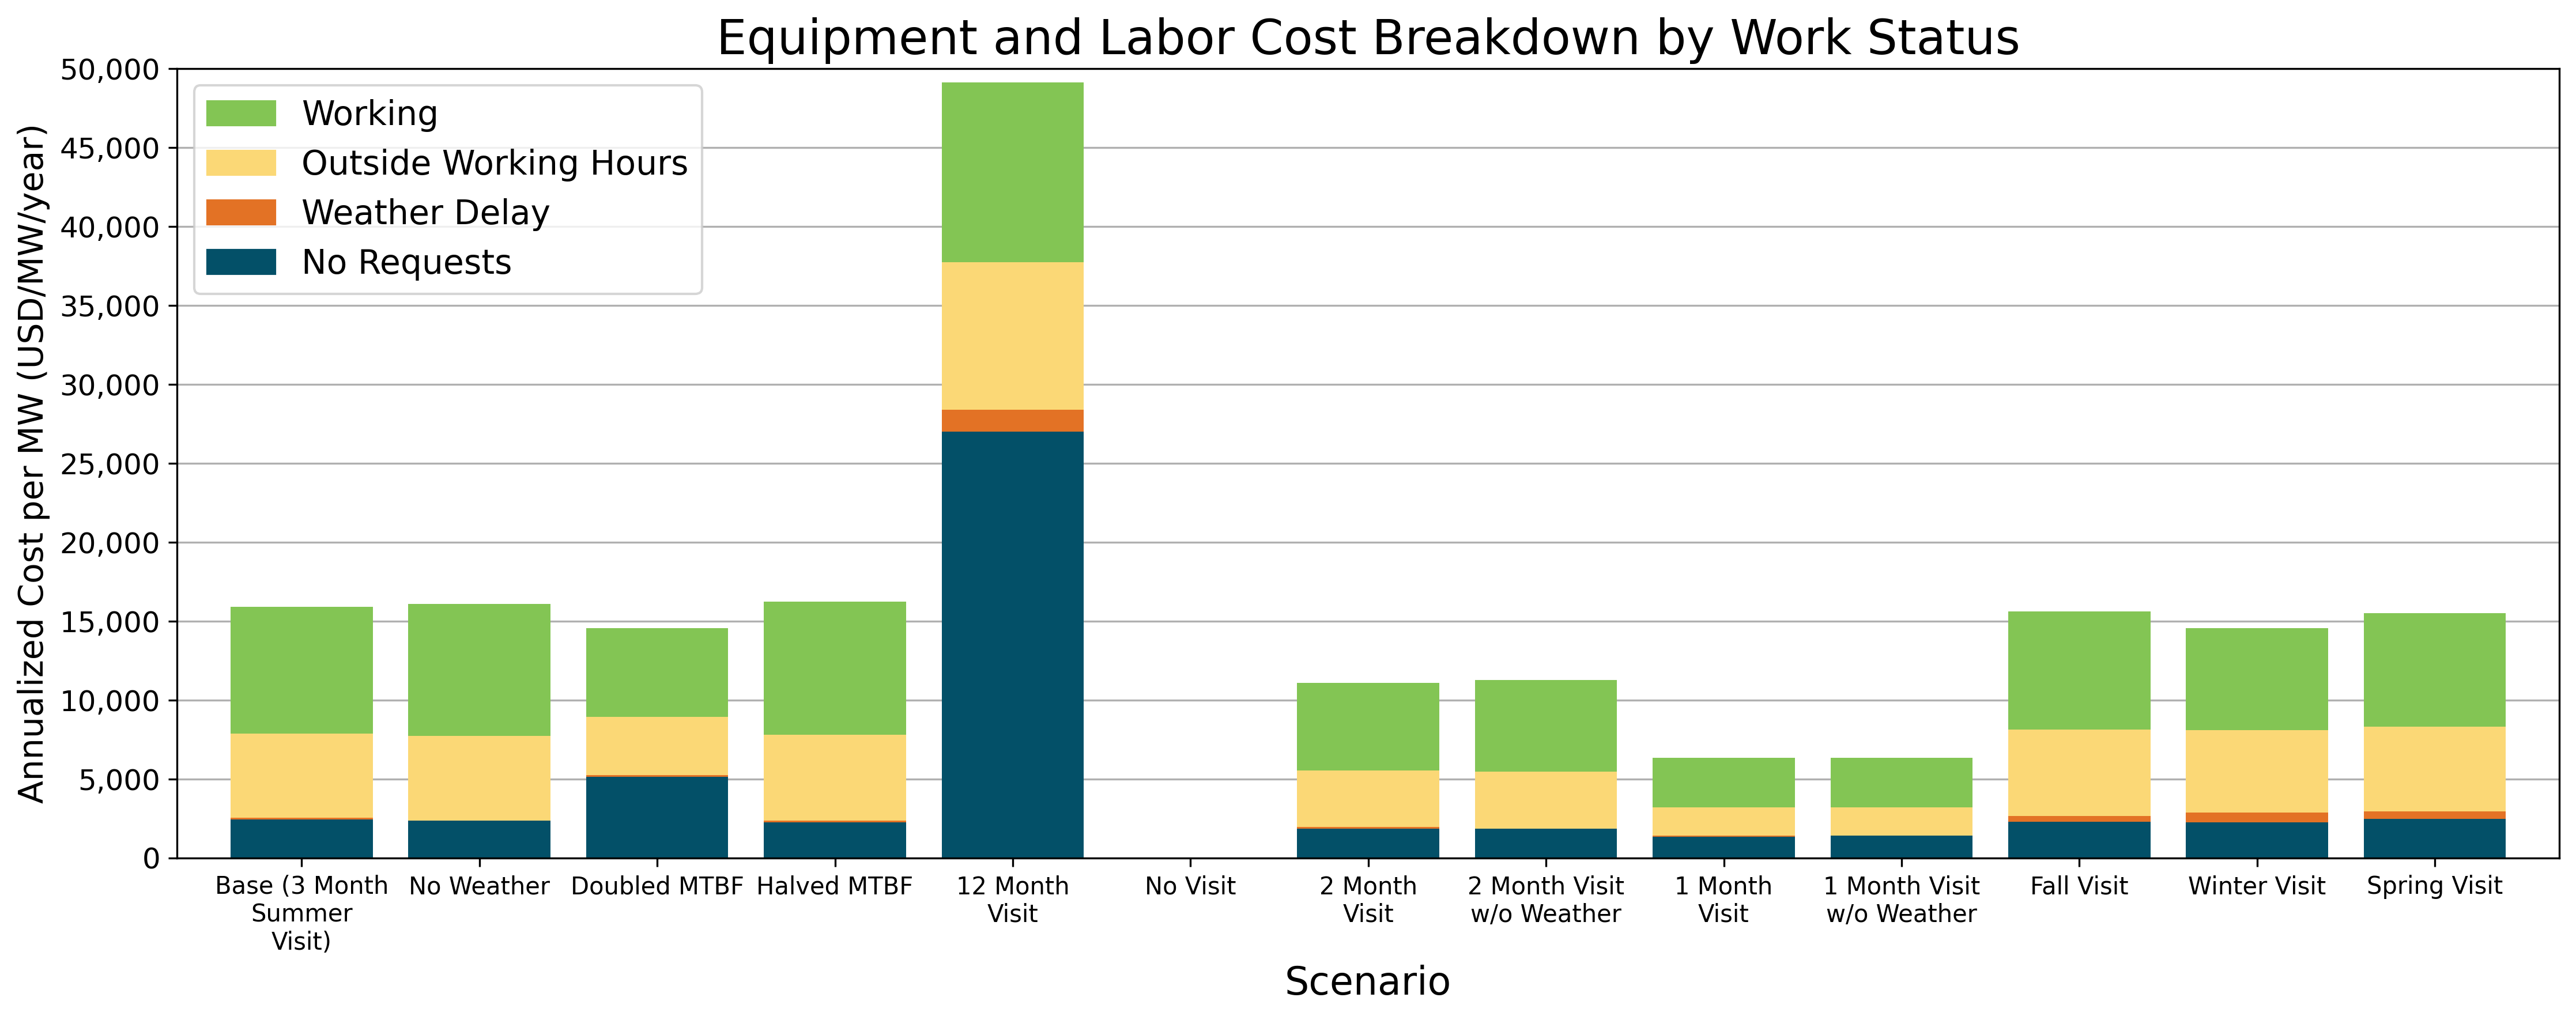

In [20]:
fig = plt.figure(figsize=(15, 6), dpi=300)
ax = fig.add_subplot(111)

colors = ["#035068", "#E37225", "#FBD876", "#83C554"]
indices = ["No Requests", "Weather Delay", "Outside Working Hours", "Working"]
_data_frames = {
    name: values for name, values in data_frames.items() if name.startswith("onshore")
}
x_tick_labels = [format_dict[s]["name"] for s in _data_frames]
y_ticks = range(0, 50001, 5000)

patches = []
for name, color in zip(indices, colors):
    patch = mpatches.Patch(color=color, label=name)
    patches.append(patch)

for i, scenario in enumerate(_data_frames):
    if all(s is None for s in scenarios[scenario][2:]):
        continue
    name = format_dict[scenario]["name"]
    events = data_frames[scenario]["events"]
    equip_labor = equipment_labor_cost_breakdown(
        events, onshore_equipment, onshore_total_mw, 20
    )

    bottom = 0
    for c, ix in zip(colors, indices):
        if ix not in equip_labor.index:
            continue
        ax.bar(i, equip_labor.loc[ix], bottom=bottom, color=c)
        bottom += equip_labor.loc[ix]

ax.set_xticks(range(len(x_tick_labels)))
ax.set_xticklabels(
    [make_label_multi_lines(x, longest_line_length=12) for x in x_tick_labels],
    fontsize=10,
)
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{y:,.0f}" for y in y_ticks], fontsize=12)

ax.set_title("Equipment and Labor Cost Breakdown by Work Status", fontsize=20)
ax.set_xlabel("Scenario", fontsize=16)
ax.set_ylabel("Annualized Cost per MW (USD/MW/year)", fontsize=14)

ax.set_xlim(-0.7, 12.7)
ax.set_ylim(0, 50000)
ax.legend(handles=list(reversed(patches)), ncol=1, fontsize=14, loc="upper left")

ax.grid(axis="y")
ax.set_axisbelow(True)

fig.tight_layout()
plt.savefig(
    os.path.join(
        library_path, "outputs/plots_and_tables/onshore_equipment_labor_breakdown.png"
    ),
    bbox_inches="tight",
)
plt.savefig(
    os.path.join(
        library_path, "outputs/plots_and_tables/onshore_equipment_labor_breakdown.svg"
    ),
    bbox_inches="tight",
)

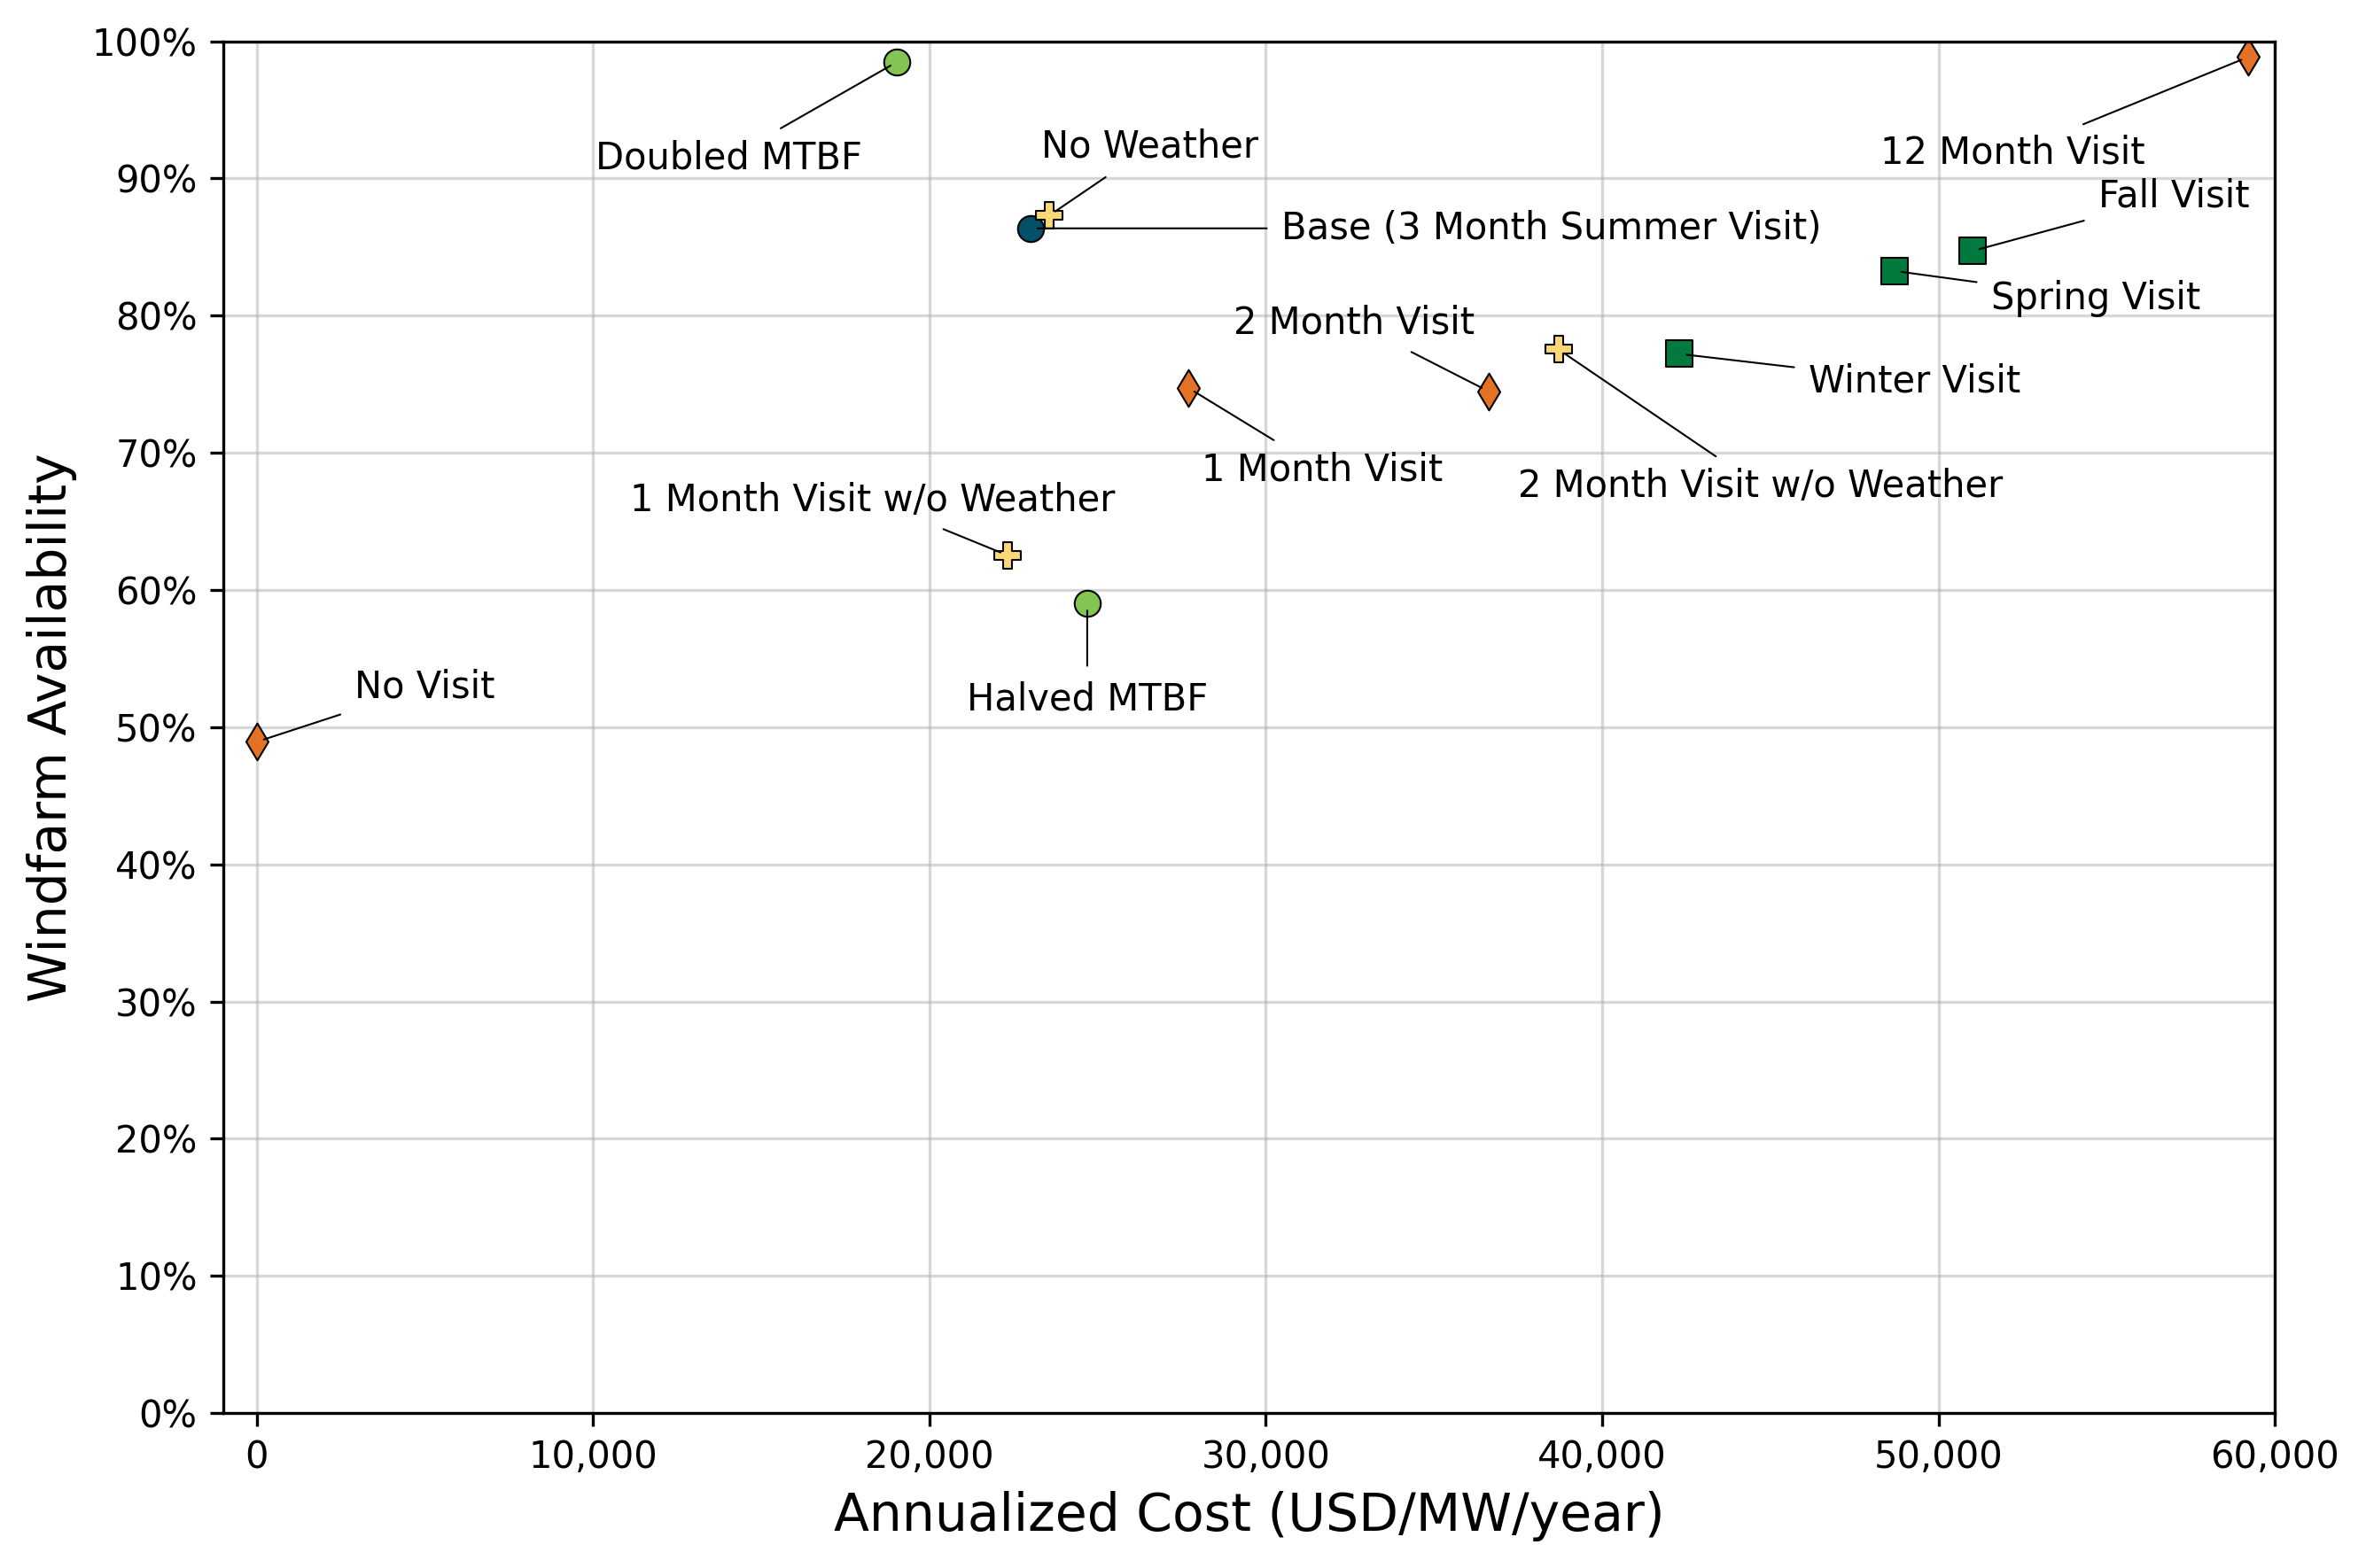

In [21]:
fig = plt.figure(figsize=(9, 6), dpi=300)
ax = fig.add_subplot(111)

x_ticks = range(0, 60001, 10000)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f"{x:,.0f}" for x in x_ticks])

y_ticks = range(0, 101, 10)
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{y:.0f}%" for y in y_ticks])

ax.grid(alpha=0.5)
ax.set_axisbelow(True)

ax.set_xlim(-1000, 60000)
ax.set_ylim(0, 100)

ax.set_xlabel("Annualized Cost (USD/MW/year)", fontsize=14)
ax.set_ylabel("Windfarm Availability", fontsize=14)

arrow_props = arrowprops = dict(arrowstyle="-", linewidth=0.5, zorder=0)

_data_frames = {
    name: values for name, values in data_frames.items() if name.startswith("onshore")
}
for scenario in _data_frames:
    name = format_dict[scenario]["name"]
    events = data_frames[scenario]["events"]
    fmt = format_dict[scenario]["format"]
    annual_mw_costs = data_frames[scenario]["events"].total_cost.sum()
    annual_mw_costs = annual_mw_costs / onshore_total_mw / len(years)
    availability = data_frames[scenario]["project_availability"] * 100
    text_positions = (annual_mw_costs, availability)
    if name == "No Visit":
        text_positions = (annual_mw_costs + 5000, availability + 4)
    elif name == "12 Month Visit":
        text_positions = (annual_mw_costs - 7000, availability - 7)
    elif name == "Doubled MTBF":
        text_positions = (annual_mw_costs - 5000, availability - 7)
    elif name == "No Weather":
        text_positions = (annual_mw_costs + 3000, availability + 5)
    elif name == "Halved MTBF":
        text_positions = (annual_mw_costs, availability - 7)
    elif name == "2 Month Visit":
        text_positions = (annual_mw_costs - 4000, availability + 5)
    elif name == "1 Month Visit":
        text_positions = (annual_mw_costs + 4000, availability - 6)
    elif name == "2 Month Visit w/o Weather":
        text_positions = (annual_mw_costs + 6000, availability - 10)
    elif name == "1 Month Visit w/o Weather":
        text_positions = (annual_mw_costs - 4000, availability + 4)
    elif name == "Fall Visit":
        text_positions = (annual_mw_costs + 6000, availability + 4)
    elif name == "Spring Visit":
        text_positions = (annual_mw_costs + 6000, availability - 2)
    elif name == "Winter Visit":
        text_positions = (annual_mw_costs + 7000, availability - 2)
    elif name == "Base (3 Month Summer Visit)":
        text_positions = (annual_mw_costs + 15500, availability)

    ax.scatter(
        annual_mw_costs,
        availability,
        s=50,
        color=fmt["marker_color"],
        marker=fmt["marker"],
        edgecolor="black",
        linewidth=0.5,
    )
    ax.annotate(
        name,
        (annual_mw_costs, availability),
        xytext=text_positions,
        xycoords="data",
        ha="center",
        va="center",
        fontsize=10,
        arrowprops=arrow_props,
    )

fig.tight_layout()
plt.savefig(
    os.path.join(
        library_path, "outputs/plots_and_tables/onshore_cost_availability.png"
    ),
    bbox_to_inches="tight",
)
plt.savefig(
    os.path.join(
        library_path, "outputs/plots_and_tables/onshore_cost_availability.svg"
    ),
    bbox_to_inches="tight",
)